In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 4.3 MB/s 
     |████████████████████████████████| 1.8 MB 67.3 MB/s 
     |████████████████████████████████| 103 kB 74.6 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
## Data split
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(data, 
                                                data['point_of_interest'], 
                                                data['point_of_interest'])):
    data.loc[val_idx, 'set'] = i

print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

valid_data = data[data['set'] == 0]
train_data = data[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Valid data: ')
analysis(valid_data)

train_poi = train_data['point_of_interest'].unique().tolist()
valid_poi = valid_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(valid_poi))

train_ids = train_data['id'].unique().tolist()
valid_ids = valid_data['id'].unique().tolist()

print(set(train_ids) & set(valid_ids))

tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['valid_ids'] = valid_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, valid_data
gc.collect()

data = data.set_index('id')
data = data.loc[tv_ids_d['valid_ids']]
data = data.reset_index()

Num of train data: 1138812
1.0    569406
0.0    569406
Name: set, dtype: int64
Train data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369987
Mean num of unique poi: 1.5389892077289202
Valid data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369985
Mean num of unique poi: 1.5389975269267673
set()
set()


In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

In [ ]:
data = data.set_index('id')
train_data = pd.read_csv(os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, 'pred.csv')))

#Check CV

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 81 kB 9.0 MB/s 
     |████████████████████████████████| 210 kB 74.5 MB/s 
     |████████████████████████████████| 78 kB 6.9 MB/s 
     |████████████████████████████████| 49 kB 4.2 MB/s 
     |████████████████████████████████| 112 kB 82.2 MB/s 
     |████████████████████████████████| 146 kB 75.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=0b617e83b52ba74008039490a58beedd1f7ea121819843d61dae829d7fc101cf
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = train_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, train_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2022-05-26 05:23:58,337] A new study created in memory with name: no-name-db50738d-f4d9-4870-ae8d-e3e4394848ca
[I 2022-05-26 05:24:17,941] Trial 0 finished with value: 0.8352653640067514 and parameters: {'threshold': 0.5663059449863233}. Best is trial 0 with value: 0.8352653640067514.


CV: 0.835265


[I 2022-05-26 05:24:37,028] Trial 1 finished with value: 0.8332748651308618 and parameters: {'threshold': 0.6594690625282407}. Best is trial 0 with value: 0.8352653640067514.


CV: 0.833275


[I 2022-05-26 05:24:56,663] Trial 2 finished with value: 0.826866892146492 and parameters: {'threshold': 0.2745618549122859}. Best is trial 0 with value: 0.8352653640067514.


CV: 0.826867


[I 2022-05-26 05:25:16,538] Trial 3 finished with value: 0.8306808687512247 and parameters: {'threshold': 0.33213943374644017}. Best is trial 0 with value: 0.8352653640067514.


CV: 0.830681


[I 2022-05-26 05:25:35,942] Trial 4 finished with value: 0.8179705870155636 and parameters: {'threshold': 0.8720559055486455}. Best is trial 0 with value: 0.8352653640067514.


CV: 0.817971


[I 2022-05-26 05:25:54,830] Trial 5 finished with value: 0.8198874856462259 and parameters: {'threshold': 0.8580563165891044}. Best is trial 0 with value: 0.8352653640067514.


CV: 0.819887


[I 2022-05-26 05:26:15,513] Trial 6 finished with value: 0.7882059869659171 and parameters: {'threshold': 0.08449160850395065}. Best is trial 0 with value: 0.8352653640067514.


CV: 0.788206


[I 2022-05-26 05:26:36,532] Trial 7 finished with value: 0.7871342013995452 and parameters: {'threshold': 0.0824398749757198}. Best is trial 0 with value: 0.8352653640067514.


CV: 0.787134


[I 2022-05-26 05:26:55,987] Trial 8 finished with value: 0.8351911765723786 and parameters: {'threshold': 0.4865180616749507}. Best is trial 0 with value: 0.8352653640067514.


CV: 0.835191


[I 2022-05-26 05:27:14,427] Trial 9 finished with value: 0.7772820755318358 and parameters: {'threshold': 0.9805289149487689}. Best is trial 0 with value: 0.8352653640067514.


CV: 0.777282


[I 2022-05-26 05:27:33,592] Trial 10 finished with value: 0.8338114953219429 and parameters: {'threshold': 0.6424265872153005}. Best is trial 0 with value: 0.8352653640067514.


CV: 0.833811


[I 2022-05-26 05:27:53,301] Trial 11 finished with value: 0.8352075125268312 and parameters: {'threshold': 0.49231218803760224}. Best is trial 0 with value: 0.8352653640067514.


CV: 0.835208


[I 2022-05-26 05:28:13,444] Trial 12 finished with value: 0.8354865137214198 and parameters: {'threshold': 0.5373392218141722}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.835487


[I 2022-05-26 05:28:32,666] Trial 13 finished with value: 0.8335510127919203 and parameters: {'threshold': 0.6503723965400413}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.833551


[I 2022-05-26 05:28:52,257] Trial 14 finished with value: 0.8309861432666015 and parameters: {'threshold': 0.3383220482959681}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.830986


[I 2022-05-26 05:29:11,487] Trial 15 finished with value: 0.8352823811593162 and parameters: {'threshold': 0.5650652071599698}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.835282


[I 2022-05-26 05:29:30,416] Trial 16 finished with value: 0.8267664658811523 and parameters: {'threshold': 0.7911260113627646}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.826766


[I 2022-05-26 05:29:50,216] Trial 17 finished with value: 0.8340070517751667 and parameters: {'threshold': 0.4170304642642768}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.834007


[I 2022-05-26 05:30:10,327] Trial 18 finished with value: 0.8236577574244062 and parameters: {'threshold': 0.2402419076579566}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.823658


[I 2022-05-26 05:30:29,380] Trial 19 finished with value: 0.8297900193340976 and parameters: {'threshold': 0.7411332725390383}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.829790


[I 2022-05-26 05:30:49,065] Trial 20 finished with value: 0.8353966010670741 and parameters: {'threshold': 0.5459433407336622}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.835397


[I 2022-05-26 05:31:08,701] Trial 21 finished with value: 0.8353888177306534 and parameters: {'threshold': 0.5468223179749306}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.835389


[I 2022-05-26 05:31:28,557] Trial 22 finished with value: 0.8341828218839884 and parameters: {'threshold': 0.42424187292533183}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.834183


[I 2022-05-26 05:31:48,041] Trial 23 finished with value: 0.8350531096058581 and parameters: {'threshold': 0.5790944489994282}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.835053


[I 2022-05-26 05:32:07,184] Trial 24 finished with value: 0.8311825282947712 and parameters: {'threshold': 0.7127231968730604}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.831183


[I 2022-05-26 05:32:26,981] Trial 25 finished with value: 0.8336111225954174 and parameters: {'threshold': 0.40368757631293717}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.833611


[I 2022-05-26 05:32:47,131] Trial 26 finished with value: 0.8354470836354031 and parameters: {'threshold': 0.5255061855836706}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.835447


[I 2022-05-26 05:33:06,701] Trial 27 finished with value: 0.8349788427093704 and parameters: {'threshold': 0.46775916534250817}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.834979


[I 2022-05-26 05:33:26,745] Trial 28 finished with value: 0.817965949893866 and parameters: {'threshold': 0.19505649607546177}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.817966


[I 2022-05-26 05:33:46,069] Trial 29 finished with value: 0.8349786435244141 and parameters: {'threshold': 0.5854590942122281}. Best is trial 12 with value: 0.8354865137214198.


CV: 0.834979


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5373392218141722

In [ ]:
score = study.best_value
print(f"CV: {score:.6f}")

CV: 0.835487


In [ ]:
class UnionFind():
    def __init__(self, n):
        self.n = n
        self.parents = [-1] * n

    def find(self, x):
        if self.parents[x] < 0:
            return x
        else:
            self.parents[x] = self.find(self.parents[x])
            return self.parents[x]

    def union(self, x, y):
        x = self.find(x)
        y = self.find(y)

        if x == y:
            return

        if self.parents[x] > self.parents[y]:
            x, y = y, x

        self.parents[x] += self.parents[y]
        self.parents[y] = x

    def size(self, x):
        return -self.parents[self.find(x)]

    def same(self, x, y):
        return self.find(x) == self.find(y)

    def members(self, x):
        root = self.find(x)
        return [i for i in range(self.n) if self.find(i) == root]

    def roots(self):
        return [i for i, x in enumerate(self.parents) if x < 0]

    def group_count(self):
        return len(self.roots())

    def all_group_members(self):
        return {r: self.members(r) for r in self.roots()}

    def __str__(self):
        return '\n'.join('{}: {}'.format(r, self.members(r)) for r in self.roots())

In [ ]:
id2idx = dict(data['index'])
idx2id = dict([(v, k) for k, v in id2idx.items()])

In [ ]:
data = data.reset_index()

In [ ]:
UFT = UnionFind(train_data['id'].nunique())

x = 0.9
train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]

for id, match_id in zip(train_pred_df['id'], train_pred_df['match_id']):
    UFT.union(id2idx[id], id2idx[match_id])

data['group'] = data['index'].map(lambda x: UFT.find(x))

idx2group_id = dict(data.groupby('group')['id'].apply(list))

{1: ['E_000007f24ebc95'],
 2: ['E_000008a8ba4f48'],
 3: ['E_00001d92066153', 'E_7e0d8e9138dd56'],
 4: ['E_000023d8f4be44'],
 5: ['E_00002a131a2bf6'],
 6: ['E_0000764d65557e', 'E_0507e10f6eb526'],
 7: ['E_00007dcd2bb53f', 'E_f131dcb7f07be9'],
 8: ['E_0000890af22ff5'],
 9: ['E_0000f17c539685'],
 10: ['E_00011cca3f0bd6', 'E_aeffddf31a4b9e'],
 11: ['E_00014f107dc217'],
 12: ['E_000177396ded71'],
 13: ['E_0001827d6b4ee2'],
 14: ['E_000184ea12d0f0'],
 15: ['E_0001968548bde2', 'E_d4dcddf5f563e5'],
 16: ['E_0001a397f67ad5'],
 17: ['E_0001b37c96a0ff'],
 18: ['E_0001e184ce8606'],
 19: ['E_00021310ea7a71', 'E_77d4badae580a8'],
 20: ['E_00024204e83804'],
 22: ['E_00028abacfbca0', 'E_0b9b4821efead1'],
 23: ['E_00028aea37a912'],
 24: ['E_00028f5a272789'],
 25: ['E_000292dce833cc', 'E_3f005f05c5c146'],
 26: ['E_0002acdcd0031b'],
 27: ['E_0002baf74f8aa3'],
 28: ['E_0002efff139ea9', 'E_d102511c1feaae'],
 29: ['E_0003337ed8ac61'],
 30: ['E_00035714ebb9bd'],
 31: ['E_0003725dff0552'],
 32: ['E_0003917138

In [ ]:
def objective(trial):
    UFT = UnionFind(train_data['id'].nunique())
    
    x = trial.suggest_uniform('threshold', 0, 1)
    train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]

    for id, match_id in zip(train_pred_df['id'], train_pred_df['match_id']):
        UFT.union(id2idx[id], id2idx[match_id])

    data['group'] = data['index'].map(lambda x: UFT.find(x))

    idx2group_id = dict(data.groupby('group')['id'].apply(list))

    out_df = pd.DataFrame()
    out_df['id'] = train_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id'].map(lambda x: idx2group_id[UFT.find(id2idx[x])])
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2022-05-26 05:59:36,192] A new study created in memory with name: no-name-2fe01397-3b0f-4c05-b1a4-145a34f7e484
[I 2022-05-26 05:59:57,378] Trial 0 finished with value: 0.8264248025049022 and parameters: {'threshold': 0.3864363563448311}. Best is trial 0 with value: 0.8264248025049022.


CV: 0.826425


[I 2022-05-26 06:00:18,272] Trial 1 finished with value: 0.8349102662096762 and parameters: {'threshold': 0.698175315229162}. Best is trial 1 with value: 0.8349102662096762.


CV: 0.834910


[I 2022-05-26 06:00:39,125] Trial 2 finished with value: 0.8312388499955522 and parameters: {'threshold': 0.453072963900374}. Best is trial 1 with value: 0.8349102662096762.


CV: 0.831239


[I 2022-05-26 06:01:00,958] Trial 3 finished with value: 0.8356872425190862 and parameters: {'threshold': 0.6610034095614654}. Best is trial 3 with value: 0.8356872425190862.


CV: 0.835687


[I 2022-05-26 06:01:21,421] Trial 4 finished with value: 0.8233062963286303 and parameters: {'threshold': 0.8660210813783975}. Best is trial 3 with value: 0.8356872425190862.


CV: 0.823306


[I 2022-05-26 06:01:43,298] Trial 5 finished with value: 0.715537445415423 and parameters: {'threshold': 0.06795994362494562}. Best is trial 3 with value: 0.8356872425190862.


CV: 0.715537


[I 2022-05-26 06:02:04,201] Trial 6 finished with value: 0.8206990128259238 and parameters: {'threshold': 0.3314932349912083}. Best is trial 3 with value: 0.8356872425190862.


CV: 0.820699


[I 2022-05-26 06:02:26,206] Trial 7 finished with value: 0.7322090126383011 and parameters: {'threshold': 0.9975642687995352}. Best is trial 3 with value: 0.8356872425190862.


CV: 0.732209


[I 2022-05-26 06:02:46,550] Trial 8 finished with value: 0.8105712500701536 and parameters: {'threshold': 0.2651077356822631}. Best is trial 3 with value: 0.8356872425190862.


CV: 0.810571


[I 2022-05-26 06:03:07,481] Trial 9 finished with value: 0.8270374484645937 and parameters: {'threshold': 0.8347634676577899}. Best is trial 3 with value: 0.8356872425190862.


CV: 0.827037


[I 2022-05-26 06:03:28,340] Trial 10 finished with value: 0.83586484455058 and parameters: {'threshold': 0.6184897583655989}. Best is trial 10 with value: 0.83586484455058.


CV: 0.835865


[I 2022-05-26 06:03:49,176] Trial 11 finished with value: 0.8359525142362233 and parameters: {'threshold': 0.6316710398118554}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.835953


[I 2022-05-26 06:04:09,939] Trial 12 finished with value: 0.8359237776181246 and parameters: {'threshold': 0.6030037066683649}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.835924


[I 2022-05-26 06:04:31,428] Trial 13 finished with value: 0.8354382410395443 and parameters: {'threshold': 0.5620340508887748}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.835438


[I 2022-05-26 06:04:51,795] Trial 14 finished with value: 0.8304355561084805 and parameters: {'threshold': 0.7958580490417888}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.830436


[I 2022-05-26 06:05:12,722] Trial 15 finished with value: 0.7927574097594986 and parameters: {'threshold': 0.19169779505933937}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.792757


[I 2022-05-26 06:05:33,587] Trial 16 finished with value: 0.8341125256410697 and parameters: {'threshold': 0.51301682661153}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.834113


[I 2022-05-26 06:05:54,542] Trial 17 finished with value: 0.8337280138991807 and parameters: {'threshold': 0.7352176735374816}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.833728


[I 2022-05-26 06:06:15,438] Trial 18 finished with value: 0.8301359266891636 and parameters: {'threshold': 0.434474952838162}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.830136


[I 2022-05-26 06:06:37,318] Trial 19 finished with value: 0.7610850076740406 and parameters: {'threshold': 0.9911723419080645}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.761085


[I 2022-05-26 06:06:57,774] Trial 20 finished with value: 0.8358947524516943 and parameters: {'threshold': 0.6097041413390538}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.835895


[I 2022-05-26 06:07:18,599] Trial 21 finished with value: 0.8356442299716846 and parameters: {'threshold': 0.5839337203867465}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.835644


[I 2022-05-26 06:07:40,020] Trial 22 finished with value: 0.8338202552178451 and parameters: {'threshold': 0.5061731362821891}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.833820


[I 2022-05-26 06:08:00,378] Trial 23 finished with value: 0.8330243583034637 and parameters: {'threshold': 0.749674661848021}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.833024


[I 2022-05-26 06:08:21,816] Trial 24 finished with value: 0.8357526105999208 and parameters: {'threshold': 0.6531807207493072}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.835753


[I 2022-05-26 06:08:42,226] Trial 25 finished with value: 0.8205105663438147 and parameters: {'threshold': 0.8841573147185332}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.820511


[I 2022-05-26 06:09:03,571] Trial 26 finished with value: 0.835436876692528 and parameters: {'threshold': 0.562322569348558}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.835437


[I 2022-05-26 06:09:23,670] Trial 27 finished with value: 0.8239747468251373 and parameters: {'threshold': 0.3609678402623364}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.823975


[I 2022-05-26 06:09:44,588] Trial 28 finished with value: 0.8329660957191873 and parameters: {'threshold': 0.7513807617826206}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.832966


[I 2022-05-26 06:10:05,240] Trial 29 finished with value: 0.830116835750774 and parameters: {'threshold': 0.4341649302470646}. Best is trial 11 with value: 0.8359525142362233.


CV: 0.830117


In [ ]:
threshold = study.best_params['threshold']
threshold

0.6316710398118554

In [ ]:
score = study.best_value
print(f"CV: {score:.6f}")

CV: 0.835953


In [ ]:
UFT = UnionFind(train_data['id'].nunique())

train_pred_df = train_data[train_data['pred'] > threshold][['id', 'match_id']]

for id, match_id in zip(train_pred_df['id'], train_pred_df['match_id']):
    UFT.union(id2idx[id], id2idx[match_id])

data['group'] = data['index'].map(lambda x: UFT.find(x))

idx2group_id = dict(data.groupby('group')['id'].apply(list))

out_df = pd.DataFrame()
out_df['id'] = train_data['id'].unique().tolist()
out_df['match_id'] = out_df['id'].map(lambda x: idx2group_id[UFT.find(id2idx[x])])
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))

(array([5.66167e+05, 1.87100e+03, 6.44000e+02, 8.80000e+01, 1.17000e+02,
        2.07000e+02, 8.40000e+01, 0.00000e+00, 1.03000e+02, 1.25000e+02]),
 array([  16. ,  226.8,  437.6,  648.4,  859.2, 1070. , 1280.8, 1491.6,
        1702.4, 1913.2, 2124. ]),
 <a list of 10 Patch objects>)

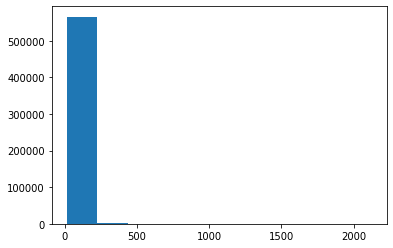

In [ ]:
out_df['matches_count'] = out_df['matches'].map(len)
plt.hist(out_df['matches_count'])

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]
    tmp = train_pred_df.groupby('id')['match_id'].apply(list)
    ids = []
    match_ids = []
    for id, match_id in tmp[tmp.map(len) == 2]:
        ids.append(id)
        match_ids.append(match_id)
    tmp_df = pd.DataFrame({'id': ids,
                           'match_id': match_ids})
    train_pred_df = pd.concat([train_pred_df, tmp_df])
    out_df = pd.DataFrame()
    out_df['id'] = train_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, train_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))

    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2022-05-26 06:37:14,177] A new study created in memory with name: no-name-c5c18ffc-de92-4f2f-89b3-e84e4b6503a4
[I 2022-05-26 06:37:44,585] Trial 0 finished with value: 0.8302329191625339 and parameters: {'threshold': 0.3236452689667385}. Best is trial 0 with value: 0.8302329191625339.


CV: 0.830233


[I 2022-05-26 06:38:15,895] Trial 1 finished with value: 0.833305483003268 and parameters: {'threshold': 0.3919226752231343}. Best is trial 1 with value: 0.833305483003268.


CV: 0.833305


[I 2022-05-26 06:38:46,313] Trial 2 finished with value: 0.823969539590405 and parameters: {'threshold': 0.822539930818213}. Best is trial 1 with value: 0.833305483003268.


CV: 0.823970


[I 2022-05-26 06:39:23,102] Trial 3 finished with value: 0.5156063808453929 and parameters: {'threshold': 0.001791150984437495}. Best is trial 1 with value: 0.833305483003268.


CV: 0.515606


[I 2022-05-26 06:39:54,124] Trial 4 finished with value: 0.8310526954788969 and parameters: {'threshold': 0.7149848456288369}. Best is trial 1 with value: 0.833305483003268.


CV: 0.831053


[I 2022-05-26 06:40:23,748] Trial 5 finished with value: 0.8353426949168662 and parameters: {'threshold': 0.5498404841451122}. Best is trial 5 with value: 0.8353426949168662.


CV: 0.835343


[I 2022-05-26 06:40:53,692] Trial 6 finished with value: 0.8326458239865456 and parameters: {'threshold': 0.3736634816546851}. Best is trial 5 with value: 0.8353426949168662.


CV: 0.832646


[I 2022-05-26 06:41:24,390] Trial 7 finished with value: 0.8328163531370172 and parameters: {'threshold': 0.6724401636374532}. Best is trial 5 with value: 0.8353426949168662.


CV: 0.832816


[I 2022-05-26 06:41:54,278] Trial 8 finished with value: 0.8341733461200668 and parameters: {'threshold': 0.4235521529989027}. Best is trial 5 with value: 0.8353426949168662.


CV: 0.834173
CV: 0.835375


[I 2022-05-26 06:42:25,063] Trial 9 finished with value: 0.8353752013683963 and parameters: {'threshold': 0.5471347849457002}. Best is trial 9 with value: 0.8353752013683963.
[I 2022-05-26 06:42:55,344] Trial 10 finished with value: 0.8040507528583523 and parameters: {'threshold': 0.1274180835512797}. Best is trial 9 with value: 0.8353752013683963.


CV: 0.804051


[I 2022-05-26 06:43:24,711] Trial 11 finished with value: 0.8346225195557111 and parameters: {'threshold': 0.6064198874773427}. Best is trial 9 with value: 0.8353752013683963.


CV: 0.834623


[I 2022-05-26 06:43:56,399] Trial 12 finished with value: 0.8354825261313769 and parameters: {'threshold': 0.5384215625418257}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.835483


[I 2022-05-26 06:44:25,780] Trial 13 finished with value: 0.7660271386207114 and parameters: {'threshold': 0.9879877405267822}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.766027


[I 2022-05-26 06:44:55,009] Trial 14 finished with value: 0.8265925384179732 and parameters: {'threshold': 0.792807042056589}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.826593


[I 2022-05-26 06:45:25,082] Trial 15 finished with value: 0.8258134721103496 and parameters: {'threshold': 0.26245821860580004}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.825813


[I 2022-05-26 06:45:56,093] Trial 16 finished with value: 0.8350400762957652 and parameters: {'threshold': 0.4752761822024911}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.835040


[I 2022-05-26 06:46:25,865] Trial 17 finished with value: 0.8354050603390897 and parameters: {'threshold': 0.5222739541007924}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.835405


[I 2022-05-26 06:46:57,298] Trial 18 finished with value: 0.8165466874994018 and parameters: {'threshold': 0.1861277274929204}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.816547


[I 2022-05-26 06:47:26,032] Trial 19 finished with value: 0.7993160438664196 and parameters: {'threshold': 0.9487429129504255}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.799316


[I 2022-05-26 06:47:55,438] Trial 20 finished with value: 0.8340073709861894 and parameters: {'threshold': 0.6345239824655431}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.834007


[I 2022-05-26 06:48:26,037] Trial 21 finished with value: 0.8353476032100476 and parameters: {'threshold': 0.5501820862337191}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.835348


[I 2022-05-26 06:48:56,087] Trial 22 finished with value: 0.8352985126955366 and parameters: {'threshold': 0.49731155577669317}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.835299


[I 2022-05-26 06:49:26,814] Trial 23 finished with value: 0.8280450589245362 and parameters: {'threshold': 0.7732797111845267}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.828045
CV: 0.835250


[I 2022-05-26 06:49:56,526] Trial 24 finished with value: 0.8352501517121493 and parameters: {'threshold': 0.5697515038848936}. Best is trial 12 with value: 0.8354825261313769.
[I 2022-05-26 06:50:27,602] Trial 25 finished with value: 0.8350628164699362 and parameters: {'threshold': 0.4763068396012133}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.835063


[I 2022-05-26 06:50:57,158] Trial 26 finished with value: 0.8194978057778515 and parameters: {'threshold': 0.8610441634538697}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.819498


[I 2022-05-26 06:51:29,816] Trial 27 finished with value: 0.8321330999774043 and parameters: {'threshold': 0.6890306138866079}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.832133


[I 2022-05-26 06:52:01,942] Trial 28 finished with value: 0.8265716400757026 and parameters: {'threshold': 0.2706974863078491}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.826572


[I 2022-05-26 06:52:32,482] Trial 29 finished with value: 0.8346459936220458 and parameters: {'threshold': 0.4461478878813429}. Best is trial 12 with value: 0.8354825261313769.


CV: 0.834646


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5384215625418257

In [ ]:
score = study.best_value
print(f"CV: {score:.6f}")

CV: 0.835483


In [ ]:
import optuna

thresholds = {}
scores = {}

for match_num in range(4, 11):
    def objective(trial):
        x = trial.suggest_uniform('threshold', 0, 1)
        train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]
        tmp = train_pred_df.groupby('id')['match_id'].apply(list)
        ids = []
        match_ids = []
        for ids_ in tmp[(2 <= tmp.map(len)) & (tmp.map(len) <= match_num)]:
            n = len(ids_)
            for i in range(n - 1):
                for j in range(i + 1, n):
                    ids.append(ids_[i])
                    match_ids.append(ids_[j])
        tmp_df = pd.DataFrame({'id': ids,
                              'match_id': match_ids})
        train_pred_df = pd.concat([train_pred_df, tmp_df])
        out_df = pd.DataFrame()
        out_df['id'] = train_data['id'].unique().tolist()
        out_df['match_id'] = out_df['id']
        out_df = pd.concat([out_df, train_pred_df])
        out_df = out_df.groupby('id')['match_id'].\
                            apply(list).reset_index()
        out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))

        out_df = post_process(out_df)

        score = get_score(out_df)
        print(f"CV: {score:.6f}")
        return score

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)

    threshold = study.best_params['threshold']
    thresholds[match_num] = threshold
    score = study.best_value
    scores[match_num] = score

[I 2022-05-26 07:10:53,593] A new study created in memory with name: no-name-d09545df-4439-4c94-9d3b-a3d9fac3b3dd
[I 2022-05-26 07:11:23,755] Trial 0 finished with value: 0.8183064362864664 and parameters: {'threshold': 0.8840977034550996}. Best is trial 0 with value: 0.8183064362864664.


CV: 0.818306


[I 2022-05-26 07:11:55,111] Trial 1 finished with value: 0.8331554625075109 and parameters: {'threshold': 0.4561526580080949}. Best is trial 1 with value: 0.8331554625075109.


CV: 0.833155


[I 2022-05-26 07:12:26,700] Trial 2 finished with value: 0.8351118462917202 and parameters: {'threshold': 0.5974397184955518}. Best is trial 2 with value: 0.8351118462917202.


CV: 0.835112


[I 2022-05-26 07:12:56,590] Trial 3 finished with value: 0.7731576282530974 and parameters: {'threshold': 0.9846770380122485}. Best is trial 2 with value: 0.8351118462917202.


CV: 0.773158


[I 2022-05-26 07:13:28,097] Trial 4 finished with value: 0.8315877169394095 and parameters: {'threshold': 0.4157369106210147}. Best is trial 2 with value: 0.8351118462917202.


CV: 0.831588


[I 2022-05-26 07:13:58,188] Trial 5 finished with value: 0.8124793258365626 and parameters: {'threshold': 0.914056766165467}. Best is trial 2 with value: 0.8351118462917202.


CV: 0.812479


[I 2022-05-26 07:14:30,278] Trial 6 finished with value: 0.8191748193134433 and parameters: {'threshold': 0.25890468104985165}. Best is trial 2 with value: 0.8351118462917202.


CV: 0.819175


[I 2022-05-26 07:15:02,806] Trial 7 finished with value: 0.8155163553038659 and parameters: {'threshold': 0.23227841278704675}. Best is trial 2 with value: 0.8351118462917202.


CV: 0.815516


[I 2022-05-26 07:15:33,184] Trial 8 finished with value: 0.8261817569484402 and parameters: {'threshold': 0.8201074937064368}. Best is trial 2 with value: 0.8351118462917202.


CV: 0.826182


[I 2022-05-26 07:16:02,801] Trial 9 finished with value: 0.7859927051569545 and parameters: {'threshold': 0.9738062086065015}. Best is trial 2 with value: 0.8351118462917202.


CV: 0.785993


[I 2022-05-26 07:16:44,830] Trial 10 finished with value: 0.45230565629824615 and parameters: {'threshold': 0.001259456171487261}. Best is trial 2 with value: 0.8351118462917202.


CV: 0.452306
CV: 0.834607


[I 2022-05-26 07:17:15,865] Trial 11 finished with value: 0.8346069033783069 and parameters: {'threshold': 0.6420276129443887}. Best is trial 2 with value: 0.8351118462917202.
[I 2022-05-26 07:17:46,761] Trial 12 finished with value: 0.8337267140226643 and parameters: {'threshold': 0.6767129770691994}. Best is trial 2 with value: 0.8351118462917202.


CV: 0.833727


[I 2022-05-26 07:18:17,495] Trial 13 finished with value: 0.8344723061982786 and parameters: {'threshold': 0.645915329066346}. Best is trial 2 with value: 0.8351118462917202.


CV: 0.834472


[I 2022-05-26 07:18:48,412] Trial 14 finished with value: 0.8343286260956997 and parameters: {'threshold': 0.6552867474677643}. Best is trial 2 with value: 0.8351118462917202.


CV: 0.834329
CV: 0.835124


[I 2022-05-26 07:19:19,418] Trial 15 finished with value: 0.8351244531706485 and parameters: {'threshold': 0.5656499023590648}. Best is trial 15 with value: 0.8351244531706485.
[I 2022-05-26 07:19:50,654] Trial 16 finished with value: 0.8347752119010873 and parameters: {'threshold': 0.5271562325851858}. Best is trial 15 with value: 0.8351244531706485.


CV: 0.834775


[I 2022-05-26 07:20:21,415] Trial 17 finished with value: 0.8298627380366054 and parameters: {'threshold': 0.7715676710791848}. Best is trial 15 with value: 0.8351244531706485.


CV: 0.829863


[I 2022-05-26 07:20:53,248] Trial 18 finished with value: 0.8254598674864962 and parameters: {'threshold': 0.3184562026045185}. Best is trial 15 with value: 0.8351244531706485.


CV: 0.825460


[I 2022-05-26 07:21:26,170] Trial 19 finished with value: 0.7896748583583018 and parameters: {'threshold': 0.12336034877242025}. Best is trial 15 with value: 0.8351244531706485.


CV: 0.789675


[I 2022-05-26 07:21:57,770] Trial 20 finished with value: 0.834991256686999 and parameters: {'threshold': 0.5423977901439987}. Best is trial 15 with value: 0.8351244531706485.


CV: 0.834991


[I 2022-05-26 07:22:29,170] Trial 21 finished with value: 0.8345532173514622 and parameters: {'threshold': 0.5120954332071905}. Best is trial 15 with value: 0.8351244531706485.


CV: 0.834553


[I 2022-05-26 07:23:00,801] Trial 22 finished with value: 0.8350874963906175 and parameters: {'threshold': 0.5598588546601737}. Best is trial 15 with value: 0.8351244531706485.


CV: 0.835087


[I 2022-05-26 07:23:32,762] Trial 23 finished with value: 0.8293477122266856 and parameters: {'threshold': 0.37211027011984577}. Best is trial 15 with value: 0.8351244531706485.


CV: 0.829348


[I 2022-05-26 07:24:03,594] Trial 24 finished with value: 0.8313116905007082 and parameters: {'threshold': 0.7420103186123264}. Best is trial 15 with value: 0.8351244531706485.


CV: 0.831312


[I 2022-05-26 07:24:34,658] Trial 25 finished with value: 0.835109323120192 and parameters: {'threshold': 0.5786026364583443}. Best is trial 15 with value: 0.8351244531706485.


CV: 0.835109
CV: 0.834954


[I 2022-05-26 07:25:05,618] Trial 26 finished with value: 0.8349536976191605 and parameters: {'threshold': 0.6088773694466263}. Best is trial 15 with value: 0.8351244531706485.
[I 2022-05-26 07:25:37,422] Trial 27 finished with value: 0.8328774962322169 and parameters: {'threshold': 0.44889449036762086}. Best is trial 15 with value: 0.8351244531706485.


CV: 0.832877


[I 2022-05-26 07:26:08,444] Trial 28 finished with value: 0.8318606375309515 and parameters: {'threshold': 0.7295182181642582}. Best is trial 15 with value: 0.8351244531706485.


CV: 0.831861
CV: 0.825004


[I 2022-05-26 07:26:38,626] Trial 29 finished with value: 0.8250042739742397 and parameters: {'threshold': 0.8333045068994239}. Best is trial 15 with value: 0.8351244531706485.
[I 2022-05-26 07:26:38,629] A new study created in memory with name: no-name-1b662b82-1843-49f5-973b-177f4fe9ae82
[I 2022-05-26 07:27:09,298] Trial 0 finished with value: 0.833755489331545 and parameters: {'threshold': 0.686235761247729}. Best is trial 0 with value: 0.833755489331545.


CV: 0.833755


[I 2022-05-26 07:27:40,315] Trial 1 finished with value: 0.8351315947923058 and parameters: {'threshold': 0.5337374371264648}. Best is trial 1 with value: 0.8351315947923058.


CV: 0.835132


[I 2022-05-26 07:28:09,829] Trial 2 finished with value: 0.8005454924298062 and parameters: {'threshold': 0.9512811284287894}. Best is trial 1 with value: 0.8351315947923058.


CV: 0.800545
CV: 0.815112


[I 2022-05-26 07:28:41,965] Trial 3 finished with value: 0.8151123847380555 and parameters: {'threshold': 0.23641668237458668}. Best is trial 1 with value: 0.8351315947923058.
[I 2022-05-26 07:29:13,354] Trial 4 finished with value: 0.8299896716985847 and parameters: {'threshold': 0.3870351604344229}. Best is trial 1 with value: 0.8351315947923058.


CV: 0.829990


[I 2022-05-26 07:29:43,845] Trial 5 finished with value: 0.8308333750446131 and parameters: {'threshold': 0.7587254800436946}. Best is trial 1 with value: 0.8351315947923058.


CV: 0.830833


[I 2022-05-26 07:30:12,588] Trial 6 finished with value: 0.7390585487605421 and parameters: {'threshold': 0.9965519914798345}. Best is trial 1 with value: 0.8351315947923058.


CV: 0.739059


[I 2022-05-26 07:30:44,213] Trial 7 finished with value: 0.8322999759158901 and parameters: {'threshold': 0.4338384248313871}. Best is trial 1 with value: 0.8351315947923058.


CV: 0.832300
CV: 0.777311


[I 2022-05-26 07:31:17,480] Trial 8 finished with value: 0.7773112056021572 and parameters: {'threshold': 0.10133096562803579}. Best is trial 1 with value: 0.8351315947923058.
[I 2022-05-26 07:31:47,689] Trial 9 finished with value: 0.8207348143566653 and parameters: {'threshold': 0.8704650004022418}. Best is trial 1 with value: 0.8351315947923058.


CV: 0.820735
CV: 0.835374


[I 2022-05-26 07:32:18,670] Trial 10 finished with value: 0.8353741292950859 and parameters: {'threshold': 0.575906393509852}. Best is trial 10 with value: 0.8353741292950859.
[I 2022-05-26 07:32:49,559] Trial 11 finished with value: 0.8353755910603483 and parameters: {'threshold': 0.5896267229854215}. Best is trial 11 with value: 0.8353755910603483.


CV: 0.835376


[I 2022-05-26 07:33:20,653] Trial 12 finished with value: 0.8353903697516056 and parameters: {'threshold': 0.5979375167085175}. Best is trial 12 with value: 0.8353903697516056.


CV: 0.835390


[I 2022-05-26 07:33:51,567] Trial 13 finished with value: 0.8340949345009351 and parameters: {'threshold': 0.6753319804120567}. Best is trial 12 with value: 0.8353903697516056.


CV: 0.834095


[I 2022-05-26 07:34:23,827] Trial 14 finished with value: 0.8250703564793676 and parameters: {'threshold': 0.31981878685108}. Best is trial 12 with value: 0.8353903697516056.


CV: 0.825070


[I 2022-05-26 07:34:54,816] Trial 15 finished with value: 0.8353747405574165 and parameters: {'threshold': 0.5741274289810159}. Best is trial 12 with value: 0.8353903697516056.


CV: 0.835375


[I 2022-05-26 07:35:25,307] Trial 16 finished with value: 0.8312351030737033 and parameters: {'threshold': 0.7508277613991137}. Best is trial 12 with value: 0.8353903697516056.


CV: 0.831235
CV: 0.815232


[I 2022-05-26 07:35:57,016] Trial 17 finished with value: 0.8152323775366099 and parameters: {'threshold': 0.23721864725208336}. Best is trial 12 with value: 0.8353903697516056.
[I 2022-05-26 07:36:31,871] Trial 18 finished with value: 0.6777976056174546 and parameters: {'threshold': 0.021303278716932827}. Best is trial 12 with value: 0.8353903697516056.


CV: 0.677798


[I 2022-05-26 07:37:02,795] Trial 19 finished with value: 0.8325429666417127 and parameters: {'threshold': 0.44001913362241774}. Best is trial 12 with value: 0.8353903697516056.


CV: 0.832543


[I 2022-05-26 07:37:32,817] Trial 20 finished with value: 0.8240574348351609 and parameters: {'threshold': 0.8455700018710667}. Best is trial 12 with value: 0.8353903697516056.


CV: 0.824057


[I 2022-05-26 07:38:03,462] Trial 21 finished with value: 0.8353769042099704 and parameters: {'threshold': 0.5965776593115857}. Best is trial 12 with value: 0.8353903697516056.


CV: 0.835377


[I 2022-05-26 07:38:33,974] Trial 22 finished with value: 0.8348127954404682 and parameters: {'threshold': 0.6455407159407736}. Best is trial 12 with value: 0.8353903697516056.


CV: 0.834813
CV: 0.834601


[I 2022-05-26 07:39:04,741] Trial 23 finished with value: 0.8346014702066022 and parameters: {'threshold': 0.5081571845158351}. Best is trial 12 with value: 0.8353903697516056.
[I 2022-05-26 07:39:34,946] Trial 24 finished with value: 0.8301907809125458 and parameters: {'threshold': 0.7730607145384433}. Best is trial 12 with value: 0.8353903697516056.


CV: 0.830191


[I 2022-05-26 07:40:05,809] Trial 25 finished with value: 0.834741363865094 and parameters: {'threshold': 0.6501823902077484}. Best is trial 12 with value: 0.8353903697516056.


CV: 0.834741


[I 2022-05-26 07:40:36,883] Trial 26 finished with value: 0.8351109542116818 and parameters: {'threshold': 0.6276959652725314}. Best is trial 12 with value: 0.8353903697516056.


CV: 0.835111


[I 2022-05-26 07:41:08,143] Trial 27 finished with value: 0.8336570609162035 and parameters: {'threshold': 0.47309679669308347}. Best is trial 12 with value: 0.8353903697516056.


CV: 0.833657


[I 2022-05-26 07:41:39,694] Trial 28 finished with value: 0.8252928137491784 and parameters: {'threshold': 0.322749589129488}. Best is trial 12 with value: 0.8353903697516056.


CV: 0.825293
CV: 0.832709


[I 2022-05-26 07:42:10,224] Trial 29 finished with value: 0.8327091836627485 and parameters: {'threshold': 0.7179242153817458}. Best is trial 12 with value: 0.8353903697516056.
[I 2022-05-26 07:42:10,227] A new study created in memory with name: no-name-d8c7804e-9ff9-4ce3-a5c4-57438de57615


CV: 0.813143


[I 2022-05-26 07:42:42,370] Trial 0 finished with value: 0.8131432466531672 and parameters: {'threshold': 0.22688648499629638}. Best is trial 0 with value: 0.8131432466531672.
[I 2022-05-26 07:43:15,373] Trial 1 finished with value: 0.7920920026130571 and parameters: {'threshold': 0.1402697920351379}. Best is trial 0 with value: 0.8131432466531672.


CV: 0.792092
CV: 0.835339


[I 2022-05-26 07:43:46,563] Trial 2 finished with value: 0.8353394421311003 and parameters: {'threshold': 0.5344059874909148}. Best is trial 2 with value: 0.8353394421311003.
[I 2022-05-26 07:44:18,401] Trial 3 finished with value: 0.8324786473743403 and parameters: {'threshold': 0.43697819936030124}. Best is trial 2 with value: 0.8353394421311003.


CV: 0.832479


[I 2022-05-26 07:44:49,181] Trial 4 finished with value: 0.8248074459082602 and parameters: {'threshold': 0.8402728980766603}. Best is trial 2 with value: 0.8353394421311003.


CV: 0.824807


[I 2022-05-26 07:45:21,962] Trial 5 finished with value: 0.7974859492889533 and parameters: {'threshold': 0.15715937627498378}. Best is trial 2 with value: 0.8353394421311003.


CV: 0.797486


[I 2022-05-26 07:45:53,690] Trial 6 finished with value: 0.8319097448167391 and parameters: {'threshold': 0.42329782244361724}. Best is trial 2 with value: 0.8353394421311003.


CV: 0.831910


[I 2022-05-26 07:46:23,960] Trial 7 finished with value: 0.80655794390029 and parameters: {'threshold': 0.9359832659058129}. Best is trial 2 with value: 0.8353394421311003.


CV: 0.806558


[I 2022-05-26 07:46:54,386] Trial 8 finished with value: 0.8263792767382233 and parameters: {'threshold': 0.8243418874845724}. Best is trial 2 with value: 0.8353394421311003.


CV: 0.826379


[I 2022-05-26 07:47:26,664] Trial 9 finished with value: 0.8019268902950106 and parameters: {'threshold': 0.17344933313223698}. Best is trial 2 with value: 0.8353394421311003.


CV: 0.801927


[I 2022-05-26 07:47:56,950] Trial 10 finished with value: 0.8350803709180092 and parameters: {'threshold': 0.6437180442915269}. Best is trial 2 with value: 0.8353394421311003.


CV: 0.835080


[I 2022-05-26 07:48:27,334] Trial 11 finished with value: 0.8353481447992475 and parameters: {'threshold': 0.6231379629807694}. Best is trial 11 with value: 0.8353481447992475.


CV: 0.835348


[I 2022-05-26 07:48:57,551] Trial 12 finished with value: 0.835404694389155 and parameters: {'threshold': 0.6145696255307274}. Best is trial 12 with value: 0.835404694389155.


CV: 0.835405


[I 2022-05-26 07:49:27,873] Trial 13 finished with value: 0.8347666350562946 and parameters: {'threshold': 0.6595873476109653}. Best is trial 12 with value: 0.835404694389155.


CV: 0.834767


[I 2022-05-26 07:49:58,047] Trial 14 finished with value: 0.8338578741376586 and parameters: {'threshold': 0.6907661777691817}. Best is trial 12 with value: 0.835404694389155.


CV: 0.833858


[I 2022-05-26 07:50:29,580] Trial 15 finished with value: 0.8253868416174949 and parameters: {'threshold': 0.324870700451055}. Best is trial 12 with value: 0.835404694389155.


CV: 0.825387
CV: 0.623721


[I 2022-05-26 07:51:05,915] Trial 16 finished with value: 0.623721343215277 and parameters: {'threshold': 0.012043055643920553}. Best is trial 12 with value: 0.835404694389155.
[I 2022-05-26 07:51:36,948] Trial 17 finished with value: 0.8355731767564517 and parameters: {'threshold': 0.5605017877081774}. Best is trial 17 with value: 0.8355731767564517.


CV: 0.835573


[I 2022-05-26 07:52:07,399] Trial 18 finished with value: 0.8353872140730976 and parameters: {'threshold': 0.5393455234765159}. Best is trial 17 with value: 0.8355731767564517.


CV: 0.835387


[I 2022-05-26 07:52:37,037] Trial 19 finished with value: 0.8273162540355145 and parameters: {'threshold': 0.8137615534251601}. Best is trial 17 with value: 0.8355731767564517.


CV: 0.827316


[I 2022-05-26 07:53:08,034] Trial 20 finished with value: 0.8276144389802582 and parameters: {'threshold': 0.3534757686900597}. Best is trial 17 with value: 0.8355731767564517.


CV: 0.827614


[I 2022-05-26 07:53:38,398] Trial 21 finished with value: 0.8354140927536614 and parameters: {'threshold': 0.5450303764584415}. Best is trial 17 with value: 0.8355731767564517.


CV: 0.835414


[I 2022-05-26 07:54:08,839] Trial 22 finished with value: 0.8354152956979543 and parameters: {'threshold': 0.545225103071919}. Best is trial 17 with value: 0.8355731767564517.


CV: 0.835415


[I 2022-05-26 07:54:39,425] Trial 23 finished with value: 0.833731033767546 and parameters: {'threshold': 0.4700438031887322}. Best is trial 17 with value: 0.8355731767564517.


CV: 0.833731


[I 2022-05-26 07:55:09,520] Trial 24 finished with value: 0.8323890298608156 and parameters: {'threshold': 0.7305367881821647}. Best is trial 17 with value: 0.8355731767564517.


CV: 0.832389


[I 2022-05-26 07:55:40,067] Trial 25 finished with value: 0.8356432571143777 and parameters: {'threshold': 0.5698584681293367}. Best is trial 25 with value: 0.8356432571143777.


CV: 0.835643


[I 2022-05-26 07:56:11,066] Trial 26 finished with value: 0.8274892005762953 and parameters: {'threshold': 0.3514354625884225}. Best is trial 25 with value: 0.8356432571143777.


CV: 0.827489


[I 2022-05-26 07:56:40,936] Trial 27 finished with value: 0.8307576692165034 and parameters: {'threshold': 0.7648576448343306}. Best is trial 25 with value: 0.8356432571143777.


CV: 0.830758


[I 2022-05-26 07:57:10,050] Trial 28 finished with value: 0.7952738416262298 and parameters: {'threshold': 0.961366611130889}. Best is trial 25 with value: 0.8356432571143777.


CV: 0.795274


[I 2022-05-26 07:57:41,248] Trial 29 finished with value: 0.821067643785971 and parameters: {'threshold': 0.2822632585042849}. Best is trial 25 with value: 0.8356432571143777.
[I 2022-05-26 07:57:41,250] A new study created in memory with name: no-name-91887657-2f7b-46aa-afde-1cf868145385


CV: 0.821068


[I 2022-05-26 07:58:11,620] Trial 0 finished with value: 0.8346469839841318 and parameters: {'threshold': 0.6704623899063552}. Best is trial 0 with value: 0.8346469839841318.


CV: 0.834647


[I 2022-05-26 07:58:44,271] Trial 1 finished with value: 0.7966207623557033 and parameters: {'threshold': 0.15581964388558667}. Best is trial 0 with value: 0.8346469839841318.


CV: 0.796621


[I 2022-05-26 07:59:13,533] Trial 2 finished with value: 0.7759427307409956 and parameters: {'threshold': 0.982959794190353}. Best is trial 0 with value: 0.8346469839841318.


CV: 0.775943


[I 2022-05-26 07:59:46,546] Trial 3 finished with value: 0.7820581164278628 and parameters: {'threshold': 0.11671222333076092}. Best is trial 0 with value: 0.8346469839841318.


CV: 0.782058


[I 2022-05-26 08:00:16,233] Trial 4 finished with value: 0.81504240505848 and parameters: {'threshold': 0.9046695050716357}. Best is trial 0 with value: 0.8346469839841318.


CV: 0.815042


[I 2022-05-26 08:00:50,944] Trial 5 finished with value: 0.8353292708946743 and parameters: {'threshold': 0.6390284118011393}. Best is trial 5 with value: 0.8353292708946743.


CV: 0.835329


[I 2022-05-26 08:01:19,957] Trial 6 finished with value: 0.7986263860984916 and parameters: {'threshold': 0.9556226594656708}. Best is trial 5 with value: 0.8353292708946743.


CV: 0.798626
CV: 0.835500


[I 2022-05-26 08:01:50,392] Trial 7 finished with value: 0.8354995065749692 and parameters: {'threshold': 0.5356821232613872}. Best is trial 7 with value: 0.8354995065749692.
[I 2022-05-26 08:02:20,267] Trial 8 finished with value: 0.8271180319662682 and parameters: {'threshold': 0.8173982362744338}. Best is trial 7 with value: 0.8354995065749692.


CV: 0.827118


[I 2022-05-26 08:02:51,708] Trial 9 finished with value: 0.8153786805854268 and parameters: {'threshold': 0.24188057108392147}. Best is trial 7 with value: 0.8354995065749692.


CV: 0.815379


[I 2022-05-26 08:03:22,752] Trial 10 finished with value: 0.829178356434397 and parameters: {'threshold': 0.37298789192302007}. Best is trial 7 with value: 0.8354995065749692.


CV: 0.829178


[I 2022-05-26 08:03:53,122] Trial 11 finished with value: 0.8357167764552085 and parameters: {'threshold': 0.577788864095708}. Best is trial 11 with value: 0.8357167764552085.


CV: 0.835717


[I 2022-05-26 08:04:23,924] Trial 12 finished with value: 0.8340303234967876 and parameters: {'threshold': 0.47651981715113756}. Best is trial 11 with value: 0.8357167764552085.


CV: 0.834030


[I 2022-05-26 08:04:54,292] Trial 13 finished with value: 0.8355962590152183 and parameters: {'threshold': 0.6096892393778314}. Best is trial 11 with value: 0.8357167764552085.


CV: 0.835596


[I 2022-05-26 08:05:24,307] Trial 14 finished with value: 0.8317622318251956 and parameters: {'threshold': 0.7477061535656899}. Best is trial 11 with value: 0.8357167764552085.


CV: 0.831762


[I 2022-05-26 08:05:55,363] Trial 15 finished with value: 0.8291144787706953 and parameters: {'threshold': 0.3719887294181421}. Best is trial 11 with value: 0.8357167764552085.


CV: 0.829114


[I 2022-05-26 08:06:25,709] Trial 16 finished with value: 0.8357056937204678 and parameters: {'threshold': 0.5895228583644505}. Best is trial 11 with value: 0.8357167764552085.


CV: 0.835706


[I 2022-05-26 08:06:57,009] Trial 17 finished with value: 0.8325393151624245 and parameters: {'threshold': 0.43521693561594715}. Best is trial 11 with value: 0.8357167764552085.


CV: 0.832539


[I 2022-05-26 08:07:29,322] Trial 18 finished with value: 0.820062171709358 and parameters: {'threshold': 0.2750672905109699}. Best is trial 11 with value: 0.8357167764552085.


CV: 0.820062


[I 2022-05-26 08:08:00,090] Trial 19 finished with value: 0.8303453849673621 and parameters: {'threshold': 0.7765827600503254}. Best is trial 11 with value: 0.8357167764552085.


CV: 0.830345


[I 2022-05-26 08:08:31,530] Trial 20 finished with value: 0.8355466718421181 and parameters: {'threshold': 0.5425074948532252}. Best is trial 11 with value: 0.8357167764552085.


CV: 0.835547


[I 2022-05-26 08:09:02,954] Trial 21 finished with value: 0.8357189376354381 and parameters: {'threshold': 0.5994488854722262}. Best is trial 21 with value: 0.8357189376354381.


CV: 0.835719


[I 2022-05-26 08:09:42,487] Trial 22 finished with value: 0.5531954480830334 and parameters: {'threshold': 0.0060177263244232115}. Best is trial 21 with value: 0.8357189376354381.


CV: 0.553195


[I 2022-05-26 08:10:12,647] Trial 23 finished with value: 0.8339597162999965 and parameters: {'threshold': 0.6938798795937341}. Best is trial 21 with value: 0.8357189376354381.


CV: 0.833960


[I 2022-05-26 08:10:43,110] Trial 24 finished with value: 0.8357461759856724 and parameters: {'threshold': 0.5864314631583235}. Best is trial 24 with value: 0.8357461759856724.


CV: 0.835746


[I 2022-05-26 08:11:12,825] Trial 25 finished with value: 0.8222698913392668 and parameters: {'threshold': 0.8615277537241364}. Best is trial 24 with value: 0.8357461759856724.


CV: 0.822270


[I 2022-05-26 08:11:43,657] Trial 26 finished with value: 0.8322328704644709 and parameters: {'threshold': 0.4277994444283686}. Best is trial 24 with value: 0.8357461759856724.


CV: 0.832233


[I 2022-05-26 08:12:13,685] Trial 27 finished with value: 0.8335649672626679 and parameters: {'threshold': 0.7051792662924039}. Best is trial 24 with value: 0.8357461759856724.


CV: 0.833565


[I 2022-05-26 08:12:44,255] Trial 28 finished with value: 0.8353529955687268 and parameters: {'threshold': 0.5292936922160534}. Best is trial 24 with value: 0.8357461759856724.


CV: 0.835353
CV: 0.835344


[I 2022-05-26 08:13:14,545] Trial 29 finished with value: 0.8353435839366761 and parameters: {'threshold': 0.6349428501187402}. Best is trial 24 with value: 0.8357461759856724.
[I 2022-05-26 08:13:14,547] A new study created in memory with name: no-name-c988fe94-e52d-41eb-97d1-9230e9724c2b
[I 2022-05-26 08:13:44,426] Trial 0 finished with value: 0.8238307289974653 and parameters: {'threshold': 0.8501403155949099}. Best is trial 0 with value: 0.8238307289974653.


CV: 0.823831


[I 2022-05-26 08:14:16,484] Trial 1 finished with value: 0.799578842918071 and parameters: {'threshold': 0.1673708832614078}. Best is trial 0 with value: 0.8238307289974653.


CV: 0.799579


[I 2022-05-26 08:14:48,561] Trial 2 finished with value: 0.8047792420356901 and parameters: {'threshold': 0.1873619335629565}. Best is trial 0 with value: 0.8238307289974653.


CV: 0.804779


[I 2022-05-26 08:15:18,554] Trial 3 finished with value: 0.8315562450952171 and parameters: {'threshold': 0.7527276835219555}. Best is trial 3 with value: 0.8315562450952171.


CV: 0.831556


[I 2022-05-26 08:15:48,110] Trial 4 finished with value: 0.8207956088919011 and parameters: {'threshold': 0.8726638684208964}. Best is trial 3 with value: 0.8315562450952171.


CV: 0.820796


[I 2022-05-26 08:16:20,448] Trial 5 finished with value: 0.7921489993644064 and parameters: {'threshold': 0.14317502887929545}. Best is trial 3 with value: 0.8315562450952171.


CV: 0.792149
CV: 0.811872


[I 2022-05-26 08:16:52,005] Trial 6 finished with value: 0.8118716945186554 and parameters: {'threshold': 0.22139245679199038}. Best is trial 3 with value: 0.8315562450952171.
[I 2022-05-26 08:17:22,630] Trial 7 finished with value: 0.8357897286562639 and parameters: {'threshold': 0.5622576303630729}. Best is trial 7 with value: 0.8357897286562639.


CV: 0.835790
CV: 0.801881


[I 2022-05-26 08:17:54,483] Trial 8 finished with value: 0.8018809005959444 and parameters: {'threshold': 0.17570441850589213}. Best is trial 7 with value: 0.8357897286562639.
[I 2022-05-26 08:18:24,586] Trial 9 finished with value: 0.8339856978932151 and parameters: {'threshold': 0.6960147715634858}. Best is trial 7 with value: 0.8357897286562639.


CV: 0.833986


[I 2022-05-26 08:18:55,321] Trial 10 finished with value: 0.8339167059383503 and parameters: {'threshold': 0.46994107593896217}. Best is trial 7 with value: 0.8357897286562639.


CV: 0.833917


[I 2022-05-26 08:19:25,813] Trial 11 finished with value: 0.835874873825822 and parameters: {'threshold': 0.5693467574831069}. Best is trial 11 with value: 0.835874873825822.


CV: 0.835875


[I 2022-05-26 08:19:56,545] Trial 12 finished with value: 0.8344772058272528 and parameters: {'threshold': 0.48706907226736457}. Best is trial 11 with value: 0.835874873825822.


CV: 0.834477


[I 2022-05-26 08:20:26,922] Trial 13 finished with value: 0.8357533521519481 and parameters: {'threshold': 0.6055475675235599}. Best is trial 11 with value: 0.835874873825822.


CV: 0.835753


[I 2022-05-26 08:20:57,957] Trial 14 finished with value: 0.8285960343342048 and parameters: {'threshold': 0.3643092569583748}. Best is trial 11 with value: 0.835874873825822.


CV: 0.828596


[I 2022-05-26 08:21:28,541] Trial 15 finished with value: 0.8356939885502068 and parameters: {'threshold': 0.6089688444916506}. Best is trial 11 with value: 0.835874873825822.


CV: 0.835694


[I 2022-05-26 08:21:59,663] Trial 16 finished with value: 0.826530606790767 and parameters: {'threshold': 0.338824985222387}. Best is trial 11 with value: 0.835874873825822.


CV: 0.826531


[I 2022-05-26 08:22:51,634] Trial 17 finished with value: 0.2723061102461286 and parameters: {'threshold': 0.000214185571346448}. Best is trial 11 with value: 0.835874873825822.


CV: 0.272306


[I 2022-05-26 08:23:20,961] Trial 18 finished with value: 0.7909401681590688 and parameters: {'threshold': 0.9679883767261566}. Best is trial 11 with value: 0.835874873825822.


CV: 0.790940
CV: 0.835796


[I 2022-05-26 08:23:51,633] Trial 19 finished with value: 0.8357959611759006 and parameters: {'threshold': 0.5831429829043541}. Best is trial 11 with value: 0.835874873825822.
[I 2022-05-26 08:24:22,214] Trial 20 finished with value: 0.8337654101839742 and parameters: {'threshold': 0.7015260328461679}. Best is trial 11 with value: 0.835874873825822.


CV: 0.833765


[I 2022-05-26 08:24:52,923] Trial 21 finished with value: 0.8358289590989121 and parameters: {'threshold': 0.5799556037901376}. Best is trial 11 with value: 0.835874873825822.


CV: 0.835829


[I 2022-05-26 08:25:23,913] Trial 22 finished with value: 0.8305223983869905 and parameters: {'threshold': 0.39342559347727213}. Best is trial 11 with value: 0.835874873825822.


CV: 0.830522


[I 2022-05-26 08:25:54,490] Trial 23 finished with value: 0.8354540076429836 and parameters: {'threshold': 0.5288926709366726}. Best is trial 11 with value: 0.835874873825822.


CV: 0.835454


[I 2022-05-26 08:26:24,610] Trial 24 finished with value: 0.8352269296837026 and parameters: {'threshold': 0.6493614100364657}. Best is trial 11 with value: 0.835874873825822.


CV: 0.835227


[I 2022-05-26 08:26:54,485] Trial 25 finished with value: 0.8299963854182857 and parameters: {'threshold': 0.7830951292383286}. Best is trial 11 with value: 0.835874873825822.


CV: 0.829996


[I 2022-05-26 08:27:25,203] Trial 26 finished with value: 0.832519636322582 and parameters: {'threshold': 0.4333108327355263}. Best is trial 11 with value: 0.835874873825822.


CV: 0.832520


[I 2022-05-26 08:27:56,429] Trial 27 finished with value: 0.8356522494282751 and parameters: {'threshold': 0.5473866191310051}. Best is trial 11 with value: 0.835874873825822.


CV: 0.835652


[I 2022-05-26 08:28:27,916] Trial 28 finished with value: 0.8203325510615247 and parameters: {'threshold': 0.2775556126573355}. Best is trial 11 with value: 0.835874873825822.


CV: 0.820333


[I 2022-05-26 08:28:57,604] Trial 29 finished with value: 0.823141688462546 and parameters: {'threshold': 0.8554717714751744}. Best is trial 11 with value: 0.835874873825822.
[I 2022-05-26 08:28:57,606] A new study created in memory with name: no-name-d7a589a5-5722-430c-bcdf-12550aebcf34


CV: 0.823142
CV: 0.834731


[I 2022-05-26 08:29:29,256] Trial 0 finished with value: 0.8347314348081427 and parameters: {'threshold': 0.4940568045772501}. Best is trial 0 with value: 0.8347314348081427.


CV: 0.717892


[I 2022-05-26 08:30:02,560] Trial 1 finished with value: 0.7178916232331254 and parameters: {'threshold': 0.04257377723868938}. Best is trial 0 with value: 0.8347314348081427.
[I 2022-05-26 08:30:33,456] Trial 2 finished with value: 0.833831959143552 and parameters: {'threshold': 0.7019325119838161}. Best is trial 0 with value: 0.8347314348081427.


CV: 0.833832


[I 2022-05-26 08:31:02,632] Trial 3 finished with value: 0.8072316306541097 and parameters: {'threshold': 0.9345449554449544}. Best is trial 0 with value: 0.8347314348081427.


CV: 0.807232


[I 2022-05-26 08:31:33,239] Trial 4 finished with value: 0.8351495197688505 and parameters: {'threshold': 0.5115073633537167}. Best is trial 4 with value: 0.8351495197688505.


CV: 0.835150


[I 2022-05-26 08:32:04,994] Trial 5 finished with value: 0.8317095670190088 and parameters: {'threshold': 0.41440357488026724}. Best is trial 4 with value: 0.8351495197688505.


CV: 0.831710


[I 2022-05-26 08:32:35,847] Trial 6 finished with value: 0.8325777038413996 and parameters: {'threshold': 0.4332267663765843}. Best is trial 4 with value: 0.8351495197688505.


CV: 0.832578


[I 2022-05-26 08:33:05,930] Trial 7 finished with value: 0.8333044641543406 and parameters: {'threshold': 0.7164366130416419}. Best is trial 4 with value: 0.8351495197688505.


CV: 0.833304


[I 2022-05-26 08:33:34,763] Trial 8 finished with value: 0.8248017173836293 and parameters: {'threshold': 0.8421514983961772}. Best is trial 4 with value: 0.8351495197688505.


CV: 0.824802


[I 2022-05-26 08:34:05,298] Trial 9 finished with value: 0.8301468221888475 and parameters: {'threshold': 0.7813607987414596}. Best is trial 4 with value: 0.8351495197688505.


CV: 0.830147


[I 2022-05-26 08:34:37,209] Trial 10 finished with value: 0.8075481309972254 and parameters: {'threshold': 0.19990013140540275}. Best is trial 4 with value: 0.8351495197688505.


CV: 0.807548


[I 2022-05-26 08:35:07,731] Trial 11 finished with value: 0.8357579370374758 and parameters: {'threshold': 0.5503208286122665}. Best is trial 11 with value: 0.8357579370374758.


CV: 0.835758


[I 2022-05-26 08:35:39,235] Trial 12 finished with value: 0.8169780433573501 and parameters: {'threshold': 0.2532963775694137}. Best is trial 11 with value: 0.8357579370374758.


CV: 0.816978


[I 2022-05-26 08:36:09,453] Trial 13 finished with value: 0.8356088485697548 and parameters: {'threshold': 0.6295518054591829}. Best is trial 11 with value: 0.8357579370374758.


CV: 0.835609


[I 2022-05-26 08:36:39,621] Trial 14 finished with value: 0.8357401605977824 and parameters: {'threshold': 0.6115900820799792}. Best is trial 11 with value: 0.8357579370374758.


CV: 0.835740
CV: 0.835884


[I 2022-05-26 08:37:10,943] Trial 15 finished with value: 0.835884342589251 and parameters: {'threshold': 0.5747044145035218}. Best is trial 15 with value: 0.835884342589251.
[I 2022-05-26 08:37:42,091] Trial 16 finished with value: 0.8252233063763965 and parameters: {'threshold': 0.3226179840381112}. Best is trial 15 with value: 0.835884342589251.


CV: 0.825223


[I 2022-05-26 08:38:12,286] Trial 17 finished with value: 0.8358959814580361 and parameters: {'threshold': 0.5999737486161165}. Best is trial 17 with value: 0.8358959814580361.


CV: 0.835896


[I 2022-05-26 08:38:41,678] Trial 18 finished with value: 0.7951010235413355 and parameters: {'threshold': 0.961750707570791}. Best is trial 17 with value: 0.8358959814580361.


CV: 0.795101


[I 2022-05-26 08:39:13,776] Trial 19 finished with value: 0.8253907870238314 and parameters: {'threshold': 0.3240892397019023}. Best is trial 17 with value: 0.8358959814580361.


CV: 0.825391


[I 2022-05-26 08:39:43,656] Trial 20 finished with value: 0.8249475678755807 and parameters: {'threshold': 0.840841979172105}. Best is trial 17 with value: 0.8358959814580361.


CV: 0.824948


[I 2022-05-26 08:40:14,098] Trial 21 finished with value: 0.8358827060569843 and parameters: {'threshold': 0.5748922846545572}. Best is trial 17 with value: 0.8358959814580361.


CV: 0.835883


[I 2022-05-26 08:40:44,624] Trial 22 finished with value: 0.8356940441123174 and parameters: {'threshold': 0.6203884434149851}. Best is trial 17 with value: 0.8358959814580361.


CV: 0.835694


[I 2022-05-26 08:41:15,592] Trial 23 finished with value: 0.834215656666998 and parameters: {'threshold': 0.6897184219530488}. Best is trial 17 with value: 0.8358959814580361.


CV: 0.834216


[I 2022-05-26 08:41:46,630] Trial 24 finished with value: 0.8323487267370706 and parameters: {'threshold': 0.42792465256804174}. Best is trial 17 with value: 0.8358959814580361.


CV: 0.832349


[I 2022-05-26 08:42:17,304] Trial 25 finished with value: 0.8357212768113134 and parameters: {'threshold': 0.5447499677322796}. Best is trial 17 with value: 0.8358959814580361.


CV: 0.835721


[I 2022-05-26 08:42:46,471] Trial 26 finished with value: 0.8308324363591145 and parameters: {'threshold': 0.7688546124302607}. Best is trial 17 with value: 0.8358959814580361.


CV: 0.830832


[I 2022-05-26 08:43:17,735] Trial 27 finished with value: 0.8358811165313158 and parameters: {'threshold': 0.5924440666710968}. Best is trial 17 with value: 0.8358959814580361.


CV: 0.835881


[I 2022-05-26 08:43:48,782] Trial 28 finished with value: 0.8338817408358955 and parameters: {'threshold': 0.4669824495828736}. Best is trial 17 with value: 0.8358959814580361.


CV: 0.833882


[I 2022-05-26 08:44:20,152] Trial 29 finished with value: 0.8281744663426065 and parameters: {'threshold': 0.3592434709761292}. Best is trial 17 with value: 0.8358959814580361.
[I 2022-05-26 08:44:20,155] A new study created in memory with name: no-name-aaf40e10-15bc-4eb6-ab15-4235d91e6d2d


CV: 0.828174


[I 2022-05-26 08:44:49,534] Trial 0 finished with value: 0.7990326403222994 and parameters: {'threshold': 0.954857226857399}. Best is trial 0 with value: 0.7990326403222994.


CV: 0.799033


[I 2022-05-26 08:45:36,031] Trial 1 finished with value: 0.4086776909739691 and parameters: {'threshold': 0.0016595409339116296}. Best is trial 0 with value: 0.7990326403222994.


CV: 0.408678


[I 2022-05-26 08:46:08,524] Trial 2 finished with value: 0.8225470613529089 and parameters: {'threshold': 0.2946986816425716}. Best is trial 2 with value: 0.8225470613529089.


CV: 0.822547


[I 2022-05-26 08:46:40,136] Trial 3 finished with value: 0.8275494395901797 and parameters: {'threshold': 0.3503034008659148}. Best is trial 3 with value: 0.8275494395901797.


CV: 0.827549


[I 2022-05-26 08:47:12,386] Trial 4 finished with value: 0.8075658236704024 and parameters: {'threshold': 0.1998143677012767}. Best is trial 3 with value: 0.8275494395901797.


CV: 0.807566


[I 2022-05-26 08:47:43,145] Trial 5 finished with value: 0.8186366452155716 and parameters: {'threshold': 0.26395695539376507}. Best is trial 3 with value: 0.8275494395901797.


CV: 0.818637


[I 2022-05-26 08:48:15,590] Trial 6 finished with value: 0.8121868212772668 and parameters: {'threshold': 0.22303745103662165}. Best is trial 3 with value: 0.8275494395901797.


CV: 0.812187
CV: 0.821882


[I 2022-05-26 08:48:47,163] Trial 7 finished with value: 0.8218821153782131 and parameters: {'threshold': 0.28895743989751455}. Best is trial 3 with value: 0.8275494395901797.
[I 2022-05-26 08:49:15,399] Trial 8 finished with value: 0.736210403324145 and parameters: {'threshold': 0.9969968509878429}. Best is trial 3 with value: 0.8275494395901797.


CV: 0.736210


[I 2022-05-26 08:49:46,255] Trial 9 finished with value: 0.8353615638233103 and parameters: {'threshold': 0.5171888066973036}. Best is trial 9 with value: 0.8353615638233103.


CV: 0.835362


[I 2022-05-26 08:50:16,363] Trial 10 finished with value: 0.8345378006699731 and parameters: {'threshold': 0.6804762620018356}. Best is trial 9 with value: 0.8353615638233103.


CV: 0.834538


[I 2022-05-26 08:50:47,354] Trial 11 finished with value: 0.8343244593546274 and parameters: {'threshold': 0.6880135095108835}. Best is trial 9 with value: 0.8353615638233103.


CV: 0.834324


[I 2022-05-26 08:51:17,888] Trial 12 finished with value: 0.8357255656031483 and parameters: {'threshold': 0.6175251338026707}. Best is trial 12 with value: 0.8357255656031483.


CV: 0.835726


[I 2022-05-26 08:51:48,613] Trial 13 finished with value: 0.8359415685050016 and parameters: {'threshold': 0.5774592336278679}. Best is trial 13 with value: 0.8359415685050016.


CV: 0.835942


[I 2022-05-26 08:52:18,058] Trial 14 finished with value: 0.8350514019284685 and parameters: {'threshold': 0.6641773339081316}. Best is trial 13 with value: 0.8359415685050016.


CV: 0.835051


[I 2022-05-26 08:52:49,698] Trial 15 finished with value: 0.8353394476411972 and parameters: {'threshold': 0.5154527984741546}. Best is trial 13 with value: 0.8359415685050016.


CV: 0.835339


[I 2022-05-26 08:53:19,861] Trial 16 finished with value: 0.8291811050620239 and parameters: {'threshold': 0.7954249010224312}. Best is trial 13 with value: 0.8359415685050016.


CV: 0.829181
CV: 0.832510


[I 2022-05-26 08:53:51,096] Trial 17 finished with value: 0.8325103591013538 and parameters: {'threshold': 0.42933214064581304}. Best is trial 13 with value: 0.8359415685050016.
[I 2022-05-26 08:54:20,982] Trial 18 finished with value: 0.8253743519129051 and parameters: {'threshold': 0.8371195610973405}. Best is trial 13 with value: 0.8359415685050016.


CV: 0.825374


[I 2022-05-26 08:54:51,818] Trial 19 finished with value: 0.8359777734180646 and parameters: {'threshold': 0.5885771138011029}. Best is trial 19 with value: 0.8359777734180646.


CV: 0.835978


[I 2022-05-26 08:55:23,169] Trial 20 finished with value: 0.8289039169274937 and parameters: {'threshold': 0.7985061608407602}. Best is trial 19 with value: 0.8359777734180646.


CV: 0.828904
CV: 0.835950


[I 2022-05-26 08:55:53,913] Trial 21 finished with value: 0.8359500864006836 and parameters: {'threshold': 0.5899790586636797}. Best is trial 19 with value: 0.8359777734180646.
[I 2022-05-26 08:56:24,675] Trial 22 finished with value: 0.8359767005322662 and parameters: {'threshold': 0.5885233435461563}. Best is trial 19 with value: 0.8359777734180646.


CV: 0.835977


[I 2022-05-26 08:56:54,660] Trial 23 finished with value: 0.8330052000472243 and parameters: {'threshold': 0.4417426311481325}. Best is trial 19 with value: 0.8359777734180646.


CV: 0.833005


[I 2022-05-26 08:57:25,362] Trial 24 finished with value: 0.8327314842608121 and parameters: {'threshold': 0.7305479677199171}. Best is trial 19 with value: 0.8359777734180646.


CV: 0.832731


[I 2022-05-26 08:57:55,986] Trial 25 finished with value: 0.8359061556442339 and parameters: {'threshold': 0.583015641485678}. Best is trial 19 with value: 0.8359777734180646.


CV: 0.835906


[I 2022-05-26 08:58:26,885] Trial 26 finished with value: 0.8323208813035109 and parameters: {'threshold': 0.426404945483863}. Best is trial 19 with value: 0.8359777734180646.


CV: 0.832321


[I 2022-05-26 08:58:56,493] Trial 27 finished with value: 0.8227355247062198 and parameters: {'threshold': 0.859044589282645}. Best is trial 19 with value: 0.8359777734180646.


CV: 0.822736
CV: 0.835776


[I 2022-05-26 08:59:27,010] Trial 28 finished with value: 0.83577630372746 and parameters: {'threshold': 0.5453001328799172}. Best is trial 19 with value: 0.8359777734180646.
[I 2022-05-26 08:59:57,426] Trial 29 finished with value: 0.8197268666064399 and parameters: {'threshold': 0.8795940250369483}. Best is trial 19 with value: 0.8359777734180646.


CV: 0.819727


In [ ]:
for match_num in range(4, 11):
    print(f"-- match_num: {match_num} --")
    threshold = thresholds[match_num]
    print(f"threshold: {threshold:.6f}")
    score = scores[match_num]
    print(f"CV: {score:.6f}")

-- match_num: 4 --
threshold: 0.565650
CV: 0.835124
-- match_num: 5 --
threshold: 0.597938
CV: 0.835390
-- match_num: 6 --
threshold: 0.569858
CV: 0.835643
-- match_num: 7 --
threshold: 0.586431
CV: 0.835746
-- match_num: 8 --
threshold: 0.569347
CV: 0.835875
-- match_num: 9 --
threshold: 0.599974
CV: 0.835896
-- match_num: 10 --
threshold: 0.588577
CV: 0.835978


In [87]:
import optuna

thresholds = {}
scores = {}

for match_num in range(11, 20):
    def objective(trial):
        x = trial.suggest_uniform('threshold', 0, 1)
        train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]
        tmp = train_pred_df.groupby('id')['match_id'].apply(list)
        ids = []
        match_ids = []
        for ids_ in tmp[(2 <= tmp.map(len)) & (tmp.map(len) <= match_num)]:
            n = len(ids_)
            for i in range(n - 1):
                for j in range(i + 1, n):
                    ids.append(ids_[i])
                    match_ids.append(ids_[j])
        tmp_df = pd.DataFrame({'id': ids,
                              'match_id': match_ids})
        train_pred_df = pd.concat([train_pred_df, tmp_df])
        out_df = pd.DataFrame()
        out_df['id'] = train_data['id'].unique().tolist()
        out_df['match_id'] = out_df['id']
        out_df = pd.concat([out_df, train_pred_df])
        out_df = out_df.groupby('id')['match_id'].\
                            apply(list).reset_index()
        out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))

        out_df = post_process(out_df)

        score = get_score(out_df)
        print(f"CV: {score:.6f}")
        return score

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)

    threshold = study.best_params['threshold']
    thresholds[match_num] = threshold
    score = study.best_value
    scores[match_num] = score

[I 2022-05-26 11:23:12,695] A new study created in memory with name: no-name-42891f5a-3757-46c4-9770-5f576a8ad7e1
[I 2022-05-26 11:23:44,222] Trial 0 finished with value: 0.8351687060362247 and parameters: {'threshold': 0.5078798892723814}. Best is trial 0 with value: 0.8351687060362247.


CV: 0.835169


[I 2022-05-26 11:24:15,936] Trial 1 finished with value: 0.8346721349275638 and parameters: {'threshold': 0.4876933738089808}. Best is trial 0 with value: 0.8351687060362247.


CV: 0.834672
CV: 0.831668


[I 2022-05-26 11:24:47,677] Trial 2 finished with value: 0.831668144414226 and parameters: {'threshold': 0.4117333928117577}. Best is trial 0 with value: 0.8351687060362247.


CV: 0.835606


[I 2022-05-26 11:25:18,695] Trial 3 finished with value: 0.8356062942026171 and parameters: {'threshold': 0.63910951028718}. Best is trial 3 with value: 0.8356062942026171.
[I 2022-05-26 11:25:49,597] Trial 4 finished with value: 0.8331387647847098 and parameters: {'threshold': 0.44420142753681446}. Best is trial 3 with value: 0.8356062942026171.


CV: 0.833139


[I 2022-05-26 11:26:21,540] Trial 5 finished with value: 0.8359616136277417 and parameters: {'threshold': 0.5556177569579395}. Best is trial 5 with value: 0.8359616136277417.


CV: 0.835962


[I 2022-05-26 11:26:52,022] Trial 6 finished with value: 0.8316384439176768 and parameters: {'threshold': 0.7530967441633689}. Best is trial 5 with value: 0.8359616136277417.


CV: 0.831638


[I 2022-05-26 11:27:22,128] Trial 7 finished with value: 0.8287450346533959 and parameters: {'threshold': 0.800957601428765}. Best is trial 5 with value: 0.8359616136277417.


CV: 0.828745


[I 2022-05-26 11:27:52,232] Trial 8 finished with value: 0.8126230763125217 and parameters: {'threshold': 0.9158386000811544}. Best is trial 5 with value: 0.8359616136277417.


CV: 0.812623
CV: 0.799227


[I 2022-05-26 11:28:26,131] Trial 9 finished with value: 0.799227413775977 and parameters: {'threshold': 0.166301879515259}. Best is trial 5 with value: 0.8359616136277417.
[I 2022-05-26 11:29:09,972] Trial 10 finished with value: 0.4941180661926463 and parameters: {'threshold': 0.004097074973919701}. Best is trial 5 with value: 0.8359616136277417.


CV: 0.494118


[I 2022-05-26 11:29:41,575] Trial 11 finished with value: 0.8354253397618262 and parameters: {'threshold': 0.6464554891618283}. Best is trial 5 with value: 0.8359616136277417.


CV: 0.835425


[I 2022-05-26 11:30:12,484] Trial 12 finished with value: 0.8358253579321112 and parameters: {'threshold': 0.6146143374801138}. Best is trial 5 with value: 0.8359616136277417.


CV: 0.835825


[I 2022-05-26 11:30:44,736] Trial 13 finished with value: 0.8205236425899824 and parameters: {'threshold': 0.2779503144073957}. Best is trial 5 with value: 0.8359616136277417.


CV: 0.820524


[I 2022-05-26 11:31:14,096] Trial 14 finished with value: 0.7768249438553566 and parameters: {'threshold': 0.9824186078004866}. Best is trial 5 with value: 0.8359616136277417.


CV: 0.776825


[I 2022-05-26 11:31:45,213] Trial 15 finished with value: 0.835671916471507 and parameters: {'threshold': 0.6339114047945574}. Best is trial 5 with value: 0.8359616136277417.


CV: 0.835672


[I 2022-05-26 11:32:16,989] Trial 16 finished with value: 0.8280532231635691 and parameters: {'threshold': 0.3563474723202262}. Best is trial 5 with value: 0.8359616136277417.


CV: 0.828053


[I 2022-05-26 11:32:48,207] Trial 17 finished with value: 0.8359919399564327 and parameters: {'threshold': 0.5648227125386206}. Best is trial 17 with value: 0.8359919399564327.


CV: 0.835992
CV: 0.816975


[I 2022-05-26 11:33:19,553] Trial 18 finished with value: 0.8169750037889962 and parameters: {'threshold': 0.2525206490447493}. Best is trial 17 with value: 0.8359919399564327.
[I 2022-05-26 11:33:50,810] Trial 19 finished with value: 0.8296487775695423 and parameters: {'threshold': 0.7892130382558159}. Best is trial 17 with value: 0.8359919399564327.


CV: 0.829649


[I 2022-05-26 11:34:21,965] Trial 20 finished with value: 0.8358451036610395 and parameters: {'threshold': 0.5497398939903554}. Best is trial 17 with value: 0.8359919399564327.


CV: 0.835845


[I 2022-05-26 11:34:53,055] Trial 21 finished with value: 0.8358175141518833 and parameters: {'threshold': 0.5443863499534867}. Best is trial 17 with value: 0.8359919399564327.


CV: 0.835818


[I 2022-05-26 11:35:23,727] Trial 22 finished with value: 0.8335384230301469 and parameters: {'threshold': 0.7120818911648064}. Best is trial 17 with value: 0.8359919399564327.


CV: 0.833538


[I 2022-05-26 11:35:54,997] Trial 23 finished with value: 0.835860333352295 and parameters: {'threshold': 0.5504126139392805}. Best is trial 17 with value: 0.8359919399564327.


CV: 0.835860


[I 2022-05-26 11:36:26,998] Trial 24 finished with value: 0.8284955165051674 and parameters: {'threshold': 0.36125818953210564}. Best is trial 17 with value: 0.8359919399564327.


CV: 0.828496


[I 2022-05-26 11:36:57,057] Trial 25 finished with value: 0.835993496222866 and parameters: {'threshold': 0.5757846476615831}. Best is trial 25 with value: 0.835993496222866.


CV: 0.835993


[I 2022-05-26 11:37:28,507] Trial 26 finished with value: 0.8345714697479976 and parameters: {'threshold': 0.6804133524355395}. Best is trial 25 with value: 0.835993496222866.


CV: 0.834571


[I 2022-05-26 11:37:58,651] Trial 27 finished with value: 0.8242962350184156 and parameters: {'threshold': 0.847144790627224}. Best is trial 25 with value: 0.835993496222866.


CV: 0.824296


[I 2022-05-26 11:38:30,181] Trial 28 finished with value: 0.8332419545773891 and parameters: {'threshold': 0.44630327253929714}. Best is trial 25 with value: 0.835993496222866.


CV: 0.833242


[I 2022-05-26 11:39:01,109] Trial 29 finished with value: 0.8359678177979255 and parameters: {'threshold': 0.5828128673306946}. Best is trial 25 with value: 0.835993496222866.
[I 2022-05-26 11:39:01,115] A new study created in memory with name: no-name-6641db54-a7b5-4b08-aae6-2e7c6e933796


CV: 0.835968


[I 2022-05-26 11:39:35,789] Trial 0 finished with value: 0.7706324379109349 and parameters: {'threshold': 0.09643129237005066}. Best is trial 0 with value: 0.7706324379109349.


CV: 0.770632


[I 2022-05-26 11:40:05,551] Trial 1 finished with value: 0.835394168816634 and parameters: {'threshold': 0.6520952813285494}. Best is trial 1 with value: 0.835394168816634.


CV: 0.835394


[I 2022-05-26 11:40:37,198] Trial 2 finished with value: 0.8354432018714767 and parameters: {'threshold': 0.6461971847847869}. Best is trial 2 with value: 0.8354432018714767.


CV: 0.835443


[I 2022-05-26 11:41:06,977] Trial 3 finished with value: 0.8098956270606655 and parameters: {'threshold': 0.9259987915943939}. Best is trial 2 with value: 0.8354432018714767.


CV: 0.809896


[I 2022-05-26 11:41:35,694] Trial 4 finished with value: 0.7479265778169232 and parameters: {'threshold': 0.9948307475898639}. Best is trial 2 with value: 0.8354432018714767.


CV: 0.747927


[I 2022-05-26 11:42:05,976] Trial 5 finished with value: 0.8252389225282877 and parameters: {'threshold': 0.8389645452379854}. Best is trial 2 with value: 0.8354432018714767.


CV: 0.825239


[I 2022-05-26 11:42:36,206] Trial 6 finished with value: 0.8245412321626602 and parameters: {'threshold': 0.8452182203005093}. Best is trial 2 with value: 0.8354432018714767.


CV: 0.824541
CV: 0.715967


[I 2022-05-26 11:43:12,075] Trial 7 finished with value: 0.7159674251497841 and parameters: {'threshold': 0.042098318448283045}. Best is trial 2 with value: 0.8354432018714767.


CV: 0.835901


[I 2022-05-26 11:43:43,173] Trial 8 finished with value: 0.8359011231689565 and parameters: {'threshold': 0.60894017657296}. Best is trial 8 with value: 0.8359011231689565.
[I 2022-05-26 11:44:14,671] Trial 9 finished with value: 0.8117825000111419 and parameters: {'threshold': 0.2202466383909335}. Best is trial 8 with value: 0.8359011231689565.


CV: 0.811783


[I 2022-05-26 11:44:47,206] Trial 10 finished with value: 0.8281137319480276 and parameters: {'threshold': 0.356436291207146}. Best is trial 8 with value: 0.8359011231689565.


CV: 0.828114


[I 2022-05-26 11:45:18,312] Trial 11 finished with value: 0.8359892907024429 and parameters: {'threshold': 0.5831675120413622}. Best is trial 11 with value: 0.8359892907024429.


CV: 0.835989


[I 2022-05-26 11:45:49,385] Trial 12 finished with value: 0.8355635637051486 and parameters: {'threshold': 0.5246351828409317}. Best is trial 11 with value: 0.8359892907024429.


CV: 0.835564


[I 2022-05-26 11:46:20,278] Trial 13 finished with value: 0.834459372271036 and parameters: {'threshold': 0.48059832310797673}. Best is trial 11 with value: 0.8359892907024429.


CV: 0.834459


[I 2022-05-26 11:46:52,230] Trial 14 finished with value: 0.8338353930065373 and parameters: {'threshold': 0.7033535811216766}. Best is trial 11 with value: 0.8359892907024429.


CV: 0.833835


[I 2022-05-26 11:47:23,039] Trial 15 finished with value: 0.833549210378877 and parameters: {'threshold': 0.452926814148002}. Best is trial 11 with value: 0.8359892907024429.


CV: 0.833549


[I 2022-05-26 11:47:56,231] Trial 16 finished with value: 0.8234166775595289 and parameters: {'threshold': 0.30186219655220436}. Best is trial 11 with value: 0.8359892907024429.


CV: 0.823417


[I 2022-05-26 11:48:27,032] Trial 17 finished with value: 0.8360514305750765 and parameters: {'threshold': 0.5866803366194828}. Best is trial 17 with value: 0.8360514305750765.


CV: 0.836051


[I 2022-05-26 11:48:57,923] Trial 18 finished with value: 0.8316775970888077 and parameters: {'threshold': 0.752462782547983}. Best is trial 17 with value: 0.8360514305750765.


CV: 0.831678


[I 2022-05-26 11:49:29,551] Trial 19 finished with value: 0.8357278075824891 and parameters: {'threshold': 0.5321481492485344}. Best is trial 17 with value: 0.8360514305750765.


CV: 0.835728
CV: 0.830417


[I 2022-05-26 11:50:01,632] Trial 20 finished with value: 0.8304172688392742 and parameters: {'threshold': 0.3884618669648511}. Best is trial 17 with value: 0.8360514305750765.


CV: 0.836050


[I 2022-05-26 11:50:32,782] Trial 21 finished with value: 0.8360495481490973 and parameters: {'threshold': 0.5890291157103938}. Best is trial 17 with value: 0.8360514305750765.
[I 2022-05-26 11:51:04,178] Trial 22 finished with value: 0.8360414360618983 and parameters: {'threshold': 0.5762165864245588}. Best is trial 17 with value: 0.8360514305750765.


CV: 0.836041
CV: 0.830738


[I 2022-05-26 11:51:35,073] Trial 23 finished with value: 0.8307376244920105 and parameters: {'threshold': 0.7716970848675565}. Best is trial 17 with value: 0.8360514305750765.
[I 2022-05-26 11:52:06,297] Trial 24 finished with value: 0.8326348330778037 and parameters: {'threshold': 0.4301085469754803}. Best is trial 17 with value: 0.8360514305750765.


CV: 0.832635


[I 2022-05-26 11:52:38,644] Trial 25 finished with value: 0.8358669684441449 and parameters: {'threshold': 0.5483752844075449}. Best is trial 17 with value: 0.8360514305750765.


CV: 0.835867


[I 2022-05-26 11:53:09,618] Trial 26 finished with value: 0.8337178563835643 and parameters: {'threshold': 0.7074747812697322}. Best is trial 17 with value: 0.8360514305750765.


CV: 0.833718


[I 2022-05-26 11:53:41,938] Trial 27 finished with value: 0.8237085251874752 and parameters: {'threshold': 0.30446675888647834}. Best is trial 17 with value: 0.8360514305750765.


CV: 0.823709


[I 2022-05-26 11:54:14,918] Trial 28 finished with value: 0.802087755483938 and parameters: {'threshold': 0.17647678810680745}. Best is trial 17 with value: 0.8360514305750765.


CV: 0.802088


[I 2022-05-26 11:54:45,079] Trial 29 finished with value: 0.8360416703795746 and parameters: {'threshold': 0.5980524212070822}. Best is trial 17 with value: 0.8360514305750765.
[I 2022-05-26 11:54:45,082] A new study created in memory with name: no-name-489a4483-7892-4122-b11f-53154332d7c6


CV: 0.836042


[I 2022-05-26 11:55:17,224] Trial 0 finished with value: 0.8358040954324263 and parameters: {'threshold': 0.5349673804212016}. Best is trial 0 with value: 0.8358040954324263.


CV: 0.835804


[I 2022-05-26 11:55:49,038] Trial 1 finished with value: 0.830330250106779 and parameters: {'threshold': 0.3864361099917104}. Best is trial 0 with value: 0.8358040954324263.


CV: 0.830330
CV: 0.725403


[I 2022-05-26 11:56:24,624] Trial 2 finished with value: 0.7254028627481244 and parameters: {'threshold': 0.04789837875126379}. Best is trial 0 with value: 0.8358040954324263.
[I 2022-05-26 11:56:54,079] Trial 3 finished with value: 0.7770611450085282 and parameters: {'threshold': 0.9822417686415726}. Best is trial 0 with value: 0.8358040954324263.


CV: 0.777061


[I 2022-05-26 11:57:24,033] Trial 4 finished with value: 0.8355756817175071 and parameters: {'threshold': 0.6415687693291869}. Best is trial 0 with value: 0.8358040954324263.


CV: 0.835576


[I 2022-05-26 11:57:55,346] Trial 5 finished with value: 0.8321001162064198 and parameters: {'threshold': 0.7453301452701593}. Best is trial 0 with value: 0.8358040954324263.


CV: 0.832100


[I 2022-05-26 11:58:25,600] Trial 6 finished with value: 0.8218866942817012 and parameters: {'threshold': 0.8652143170995868}. Best is trial 0 with value: 0.8358040954324263.


CV: 0.821887


[I 2022-05-26 11:59:00,357] Trial 7 finished with value: 0.752088601715487 and parameters: {'threshold': 0.07097672826764312}. Best is trial 0 with value: 0.8358040954324263.


CV: 0.752089


[I 2022-05-26 11:59:33,240] Trial 8 finished with value: 0.8090934880090925 and parameters: {'threshold': 0.20623217617081957}. Best is trial 0 with value: 0.8358040954324263.


CV: 0.809093


[I 2022-05-26 12:00:03,925] Trial 9 finished with value: 0.8331439092250199 and parameters: {'threshold': 0.44213268695825947}. Best is trial 0 with value: 0.8358040954324263.


CV: 0.833144


[I 2022-05-26 12:00:35,758] Trial 10 finished with value: 0.8357407314662761 and parameters: {'threshold': 0.6289557913110972}. Best is trial 0 with value: 0.8358040954324263.


CV: 0.835741


[I 2022-05-26 12:01:07,069] Trial 11 finished with value: 0.8360477577252973 and parameters: {'threshold': 0.5962836836842879}. Best is trial 11 with value: 0.8360477577252973.


CV: 0.836048
CV: 0.835864


[I 2022-05-26 12:01:38,362] Trial 12 finished with value: 0.8358644363468342 and parameters: {'threshold': 0.5420867481706808}. Best is trial 11 with value: 0.8360477577252973.
[I 2022-05-26 12:02:10,617] Trial 13 finished with value: 0.8250443380488747 and parameters: {'threshold': 0.3182649621509068}. Best is trial 11 with value: 0.8360477577252973.


CV: 0.825044


[I 2022-05-26 12:02:41,873] Trial 14 finished with value: 0.8361028931942138 and parameters: {'threshold': 0.5680635769913669}. Best is trial 14 with value: 0.8361028931942138.


CV: 0.836103


[I 2022-05-26 12:03:12,565] Trial 15 finished with value: 0.831286578319908 and parameters: {'threshold': 0.7614164675279538}. Best is trial 14 with value: 0.8361028931942138.


CV: 0.831287
CV: 0.834759


[I 2022-05-26 12:03:43,543] Trial 16 finished with value: 0.8347593471609818 and parameters: {'threshold': 0.6756233164363488}. Best is trial 14 with value: 0.8361028931942138.
[I 2022-05-26 12:04:14,853] Trial 17 finished with value: 0.818433856215069 and parameters: {'threshold': 0.2616678073803117}. Best is trial 14 with value: 0.8361028931942138.


CV: 0.818434


[I 2022-05-26 12:04:45,867] Trial 18 finished with value: 0.8229784943733788 and parameters: {'threshold': 0.8573067111711035}. Best is trial 14 with value: 0.8361028931942138.


CV: 0.822978


[I 2022-05-26 12:05:17,930] Trial 19 finished with value: 0.8342135956135839 and parameters: {'threshold': 0.47220586134163}. Best is trial 14 with value: 0.8361028931942138.


CV: 0.834214


[I 2022-05-26 12:05:49,364] Trial 20 finished with value: 0.8359957156075322 and parameters: {'threshold': 0.581986978998194}. Best is trial 14 with value: 0.8361028931942138.


CV: 0.835996


[I 2022-05-26 12:06:20,781] Trial 21 finished with value: 0.8360080856625407 and parameters: {'threshold': 0.561940578347376}. Best is trial 14 with value: 0.8361028931942138.


CV: 0.836008
CV: 0.830040


[I 2022-05-26 12:06:51,693] Trial 22 finished with value: 0.8300396157169307 and parameters: {'threshold': 0.382079583794093}. Best is trial 14 with value: 0.8361028931942138.
[I 2022-05-26 12:07:23,230] Trial 23 finished with value: 0.8318698711503888 and parameters: {'threshold': 0.7490538557420587}. Best is trial 14 with value: 0.8361028931942138.


CV: 0.831870


[I 2022-05-26 12:07:54,876] Trial 24 finished with value: 0.8343863128300896 and parameters: {'threshold': 0.47724202800222754}. Best is trial 14 with value: 0.8361028931942138.


CV: 0.834386
CV: 0.834585


[I 2022-05-26 12:08:26,020] Trial 25 finished with value: 0.8345845812983717 and parameters: {'threshold': 0.6801662842614964}. Best is trial 14 with value: 0.8361028931942138.
[I 2022-05-26 12:08:57,697] Trial 26 finished with value: 0.8360361836429316 and parameters: {'threshold': 0.5798255210033194}. Best is trial 14 with value: 0.8361028931942138.


CV: 0.836036


[I 2022-05-26 12:09:27,408] Trial 27 finished with value: 0.8242049396476776 and parameters: {'threshold': 0.8479330230777173}. Best is trial 14 with value: 0.8361028931942138.


CV: 0.824205


[I 2022-05-26 12:10:00,212] Trial 28 finished with value: 0.8304474972599881 and parameters: {'threshold': 0.3883626868547264}. Best is trial 14 with value: 0.8361028931942138.


CV: 0.830447


[I 2022-05-26 12:10:31,662] Trial 29 finished with value: 0.8360102392723912 and parameters: {'threshold': 0.5849805869677999}. Best is trial 14 with value: 0.8361028931942138.
[I 2022-05-26 12:10:31,665] A new study created in memory with name: no-name-6b549588-6cae-4622-a75a-440985b5fe3a


CV: 0.836010


[I 2022-05-26 12:11:04,118] Trial 0 finished with value: 0.8231068422603005 and parameters: {'threshold': 0.29820859285959156}. Best is trial 0 with value: 0.8231068422603005.


CV: 0.823107


[I 2022-05-26 12:11:35,447] Trial 1 finished with value: 0.8355980184737044 and parameters: {'threshold': 0.6408296793061666}. Best is trial 1 with value: 0.8355980184737044.


CV: 0.835598
CV: 0.833093


[I 2022-05-26 12:12:06,170] Trial 2 finished with value: 0.833092548650818 and parameters: {'threshold': 0.4399434009090457}. Best is trial 1 with value: 0.8355980184737044.
[I 2022-05-26 12:12:39,078] Trial 3 finished with value: 0.8280924076339616 and parameters: {'threshold': 0.35525849490450867}. Best is trial 1 with value: 0.8355980184737044.


CV: 0.828092


[I 2022-05-26 12:13:09,936] Trial 4 finished with value: 0.8332060295993459 and parameters: {'threshold': 0.7202959754448497}. Best is trial 1 with value: 0.8355980184737044.


CV: 0.833206


[I 2022-05-26 12:13:41,535] Trial 5 finished with value: 0.8356777605227319 and parameters: {'threshold': 0.5285800575483302}. Best is trial 5 with value: 0.8356777605227319.


CV: 0.835678
CV: 0.809790


[I 2022-05-26 12:14:14,472] Trial 6 finished with value: 0.8097901066387013 and parameters: {'threshold': 0.20939008103387124}. Best is trial 5 with value: 0.8356777605227319.


CV: 0.834476


[I 2022-05-26 12:14:45,150] Trial 7 finished with value: 0.8344762116017651 and parameters: {'threshold': 0.4792573339059367}. Best is trial 5 with value: 0.8356777605227319.
[I 2022-05-26 12:15:19,656] Trial 8 finished with value: 0.7821570958766323 and parameters: {'threshold': 0.11847301884585659}. Best is trial 5 with value: 0.8356777605227319.


CV: 0.782157


[I 2022-05-26 12:15:51,120] Trial 9 finished with value: 0.8353113841721204 and parameters: {'threshold': 0.5107594237367669}. Best is trial 5 with value: 0.8356777605227319.


CV: 0.835311


[I 2022-05-26 12:16:21,089] Trial 10 finished with value: 0.817422293731201 and parameters: {'threshold': 0.8930774408852478}. Best is trial 5 with value: 0.8356777605227319.


CV: 0.817422


[I 2022-05-26 12:16:52,364] Trial 11 finished with value: 0.8345456491260088 and parameters: {'threshold': 0.682471673999086}. Best is trial 5 with value: 0.8356777605227319.


CV: 0.834546


[I 2022-05-26 12:17:23,847] Trial 12 finished with value: 0.8352426965485498 and parameters: {'threshold': 0.6609544770446704}. Best is trial 5 with value: 0.8356777605227319.


CV: 0.835243


[I 2022-05-26 12:17:54,268] Trial 13 finished with value: 0.8155529755068227 and parameters: {'threshold': 0.9025633318743063}. Best is trial 5 with value: 0.8356777605227319.


CV: 0.815553


[I 2022-05-26 12:18:25,439] Trial 14 finished with value: 0.8360815758787581 and parameters: {'threshold': 0.5872652999630498}. Best is trial 14 with value: 0.8360815758787581.


CV: 0.836082


[I 2022-05-26 12:18:55,867] Trial 15 finished with value: 0.8359042330595272 and parameters: {'threshold': 0.5482623172269528}. Best is trial 14 with value: 0.8360815758787581.


CV: 0.835904


[I 2022-05-26 12:19:27,046] Trial 16 finished with value: 0.8269471154299326 and parameters: {'threshold': 0.8211178816858153}. Best is trial 14 with value: 0.8360815758787581.


CV: 0.826947


[I 2022-05-26 12:20:04,182] Trial 17 finished with value: 0.6913327684147328 and parameters: {'threshold': 0.030854265887443222}. Best is trial 14 with value: 0.8360815758787581.


CV: 0.691333


[I 2022-05-26 12:20:35,642] Trial 18 finished with value: 0.8360468043738462 and parameters: {'threshold': 0.5785463422903847}. Best is trial 14 with value: 0.8360815758787581.


CV: 0.836047


[I 2022-05-26 12:21:04,906] Trial 19 finished with value: 0.7641031802592808 and parameters: {'threshold': 0.9896684592343052}. Best is trial 14 with value: 0.8360815758787581.


CV: 0.764103


[I 2022-05-26 12:21:36,040] Trial 20 finished with value: 0.828091413721896 and parameters: {'threshold': 0.35549271623912454}. Best is trial 14 with value: 0.8360815758787581.


CV: 0.828091


[I 2022-05-26 12:22:08,154] Trial 21 finished with value: 0.8359339602766279 and parameters: {'threshold': 0.550617817533313}. Best is trial 14 with value: 0.8360815758787581.


CV: 0.835934
CV: 0.836046


[I 2022-05-26 12:22:39,248] Trial 22 finished with value: 0.8360461821886228 and parameters: {'threshold': 0.5914861139700164}. Best is trial 14 with value: 0.8360815758787581.
[I 2022-05-26 12:23:10,013] Trial 23 finished with value: 0.8306749977272307 and parameters: {'threshold': 0.7744108346792933}. Best is trial 14 with value: 0.8360815758787581.


CV: 0.830675
CV: 0.836067


[I 2022-05-26 12:23:41,208] Trial 24 finished with value: 0.836067016091323 and parameters: {'threshold': 0.5969273980952076}. Best is trial 14 with value: 0.8360815758787581.
[I 2022-05-26 12:24:10,830] Trial 25 finished with value: 0.8307121064040582 and parameters: {'threshold': 0.7735413812595513}. Best is trial 14 with value: 0.8360815758787581.


CV: 0.830712
CV: 0.832108


[I 2022-05-26 12:24:43,284] Trial 26 finished with value: 0.8321081960476607 and parameters: {'threshold': 0.41796293624826975}. Best is trial 14 with value: 0.8360815758787581.
[I 2022-05-26 12:25:14,535] Trial 27 finished with value: 0.8358180006360747 and parameters: {'threshold': 0.6188478555821284}. Best is trial 14 with value: 0.8360815758787581.


CV: 0.835818


[I 2022-05-26 12:25:45,285] Trial 28 finished with value: 0.8327065466516879 and parameters: {'threshold': 0.7323564749434691}. Best is trial 14 with value: 0.8360815758787581.


CV: 0.832707


[I 2022-05-26 12:26:17,416] Trial 29 finished with value: 0.8217529258146375 and parameters: {'threshold': 0.28654034022397823}. Best is trial 14 with value: 0.8360815758787581.
[I 2022-05-26 12:26:17,418] A new study created in memory with name: no-name-8ac90d7f-524b-4405-841a-14320b547ee0


CV: 0.821753


[I 2022-05-26 12:26:50,264] Trial 0 finished with value: 0.7978356631493232 and parameters: {'threshold': 0.16067672030511082}. Best is trial 0 with value: 0.7978356631493232.


CV: 0.797836


[I 2022-05-26 12:27:21,152] Trial 1 finished with value: 0.8355976718526685 and parameters: {'threshold': 0.6428690898648595}. Best is trial 1 with value: 0.8355976718526685.


CV: 0.835598


[I 2022-05-26 12:27:49,692] Trial 2 finished with value: 0.8104863723974397 and parameters: {'threshold': 0.9239303127646337}. Best is trial 1 with value: 0.8355976718526685.


CV: 0.810486


[I 2022-05-26 12:28:20,564] Trial 3 finished with value: 0.8328000707991303 and parameters: {'threshold': 0.7300516150683893}. Best is trial 1 with value: 0.8355976718526685.


CV: 0.832800
CV: 0.833267


[I 2022-05-26 12:28:50,989] Trial 4 finished with value: 0.8332666363323981 and parameters: {'threshold': 0.7189316603036408}. Best is trial 1 with value: 0.8355976718526685.
[I 2022-05-26 12:29:18,746] Trial 5 finished with value: 0.6983911680303216 and parameters: {'threshold': 0.9996576299976917}. Best is trial 1 with value: 0.8355976718526685.


CV: 0.698391


[I 2022-05-26 12:29:49,189] Trial 6 finished with value: 0.8351847291309569 and parameters: {'threshold': 0.6624837911972581}. Best is trial 1 with value: 0.8355976718526685.


CV: 0.835185


[I 2022-05-26 12:30:21,273] Trial 7 finished with value: 0.8350658734131895 and parameters: {'threshold': 0.49918762807259787}. Best is trial 1 with value: 0.8355976718526685.


CV: 0.835066


[I 2022-05-26 12:30:52,820] Trial 8 finished with value: 0.8162046820133343 and parameters: {'threshold': 0.246259283779525}. Best is trial 1 with value: 0.8355976718526685.


CV: 0.816205


[I 2022-05-26 12:31:24,827] Trial 9 finished with value: 0.8356460502212786 and parameters: {'threshold': 0.5270221770531686}. Best is trial 9 with value: 0.8356460502212786.


CV: 0.835646
CV: 0.831846


[I 2022-05-26 12:31:56,429] Trial 10 finished with value: 0.8318461118313873 and parameters: {'threshold': 0.41321420787691665}. Best is trial 9 with value: 0.8356460502212786.
[I 2022-05-26 12:32:27,997] Trial 11 finished with value: 0.8302888644030437 and parameters: {'threshold': 0.38507513541531274}. Best is trial 9 with value: 0.8356460502212786.


CV: 0.830289


[I 2022-05-26 12:32:58,739] Trial 12 finished with value: 0.8357392208518696 and parameters: {'threshold': 0.632766948425471}. Best is trial 12 with value: 0.8357392208518696.


CV: 0.835739
CV: 0.835922


[I 2022-05-26 12:33:29,714] Trial 13 finished with value: 0.8359219568432807 and parameters: {'threshold': 0.5502908626034052}. Best is trial 13 with value: 0.8359219568432807.
[I 2022-05-26 12:33:58,747] Trial 14 finished with value: 0.8241962927808886 and parameters: {'threshold': 0.8481010261919886}. Best is trial 13 with value: 0.8359219568432807.


CV: 0.824196
CV: 0.826233


[I 2022-05-26 12:34:31,115] Trial 15 finished with value: 0.8262330100125572 and parameters: {'threshold': 0.33130628763720094}. Best is trial 13 with value: 0.8359219568432807.
[I 2022-05-26 12:35:29,804] Trial 16 finished with value: 0.3525211509806348 and parameters: {'threshold': 0.0011465050034918933}. Best is trial 13 with value: 0.8359219568432807.


CV: 0.352521


[I 2022-05-26 12:36:00,819] Trial 17 finished with value: 0.8358935201372892 and parameters: {'threshold': 0.5465993365819183}. Best is trial 13 with value: 0.8359219568432807.


CV: 0.835894


[I 2022-05-26 12:36:31,133] Trial 18 finished with value: 0.8348596336601055 and parameters: {'threshold': 0.4928753981736491}. Best is trial 13 with value: 0.8359219568432807.


CV: 0.834860


[I 2022-05-26 12:37:01,919] Trial 19 finished with value: 0.8269489538051412 and parameters: {'threshold': 0.8211626521710306}. Best is trial 13 with value: 0.8359219568432807.


CV: 0.826949


[I 2022-05-26 12:37:32,959] Trial 20 finished with value: 0.835558940866374 and parameters: {'threshold': 0.5229843267744537}. Best is trial 13 with value: 0.8359219568432807.


CV: 0.835559


[I 2022-05-26 12:38:03,638] Trial 21 finished with value: 0.8360533249650515 and parameters: {'threshold': 0.6006143379031608}. Best is trial 21 with value: 0.8360533249650515.


CV: 0.836053


[I 2022-05-26 12:38:34,473] Trial 22 finished with value: 0.8360874407053573 and parameters: {'threshold': 0.5722640975288155}. Best is trial 22 with value: 0.8360874407053573.


CV: 0.836087


[I 2022-05-26 12:39:05,280] Trial 23 finished with value: 0.8360969330009509 and parameters: {'threshold': 0.5879750236447603}. Best is trial 23 with value: 0.8360969330009509.


CV: 0.836097


[I 2022-05-26 12:39:35,282] Trial 24 finished with value: 0.8304222674221374 and parameters: {'threshold': 0.7784100156204019}. Best is trial 23 with value: 0.8360969330009509.


CV: 0.830422


[I 2022-05-26 12:40:07,542] Trial 25 finished with value: 0.8323312699258584 and parameters: {'threshold': 0.4225515313247894}. Best is trial 23 with value: 0.8360969330009509.


CV: 0.832331


[I 2022-05-26 12:40:37,428] Trial 26 finished with value: 0.8358418462115097 and parameters: {'threshold': 0.6221097966717866}. Best is trial 23 with value: 0.8360969330009509.


CV: 0.835842
CV: 0.822995


[I 2022-05-26 12:41:10,356] Trial 27 finished with value: 0.8229950133047242 and parameters: {'threshold': 0.2969481805907932}. Best is trial 23 with value: 0.8360969330009509.
[I 2022-05-26 12:41:41,701] Trial 28 finished with value: 0.8334732910750622 and parameters: {'threshold': 0.714720212974871}. Best is trial 23 with value: 0.8360969330009509.


CV: 0.833473


[I 2022-05-26 12:42:14,146] Trial 29 finished with value: 0.7942471648526084 and parameters: {'threshold': 0.14931659472375847}. Best is trial 23 with value: 0.8360969330009509.
[I 2022-05-26 12:42:14,149] A new study created in memory with name: no-name-b138118e-0282-4e8e-9af1-5b3df01343da


CV: 0.794247


[I 2022-05-26 12:42:44,928] Trial 0 finished with value: 0.8198748636234684 and parameters: {'threshold': 0.8790174566993071}. Best is trial 0 with value: 0.8198748636234684.


CV: 0.819875


[I 2022-05-26 12:43:16,998] Trial 1 finished with value: 0.8247804746599448 and parameters: {'threshold': 0.3149421942128007}. Best is trial 1 with value: 0.8247804746599448.


CV: 0.824780


[I 2022-05-26 12:44:02,500] Trial 2 finished with value: 0.5256585578366367 and parameters: {'threshold': 0.005824000694837128}. Best is trial 1 with value: 0.8247804746599448.


CV: 0.525659


[I 2022-05-26 12:44:34,098] Trial 3 finished with value: 0.8334622022220476 and parameters: {'threshold': 0.44879735187180014}. Best is trial 3 with value: 0.8334622022220476.


CV: 0.833462


[I 2022-05-26 12:45:04,472] Trial 4 finished with value: 0.823325545572624 and parameters: {'threshold': 0.8548991384833161}. Best is trial 3 with value: 0.8334622022220476.


CV: 0.823326


[I 2022-05-26 12:45:35,038] Trial 5 finished with value: 0.8311856024909157 and parameters: {'threshold': 0.40099743372727303}. Best is trial 3 with value: 0.8334622022220476.


CV: 0.831186


[I 2022-05-26 12:46:06,754] Trial 6 finished with value: 0.8360853891630805 and parameters: {'threshold': 0.597699114411049}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.836085


[I 2022-05-26 12:46:37,547] Trial 7 finished with value: 0.8360200859052627 and parameters: {'threshold': 0.5819091647476462}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.836020


[I 2022-05-26 12:47:08,481] Trial 8 finished with value: 0.836073823697156 and parameters: {'threshold': 0.5767476025068755}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.836074


[I 2022-05-26 12:47:38,278] Trial 9 finished with value: 0.8356733059286424 and parameters: {'threshold': 0.6366914408239168}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.835673


[I 2022-05-26 12:48:11,704] Trial 10 finished with value: 0.8056647529306328 and parameters: {'threshold': 0.19069105734662473}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.805665


[I 2022-05-26 12:48:42,291] Trial 11 finished with value: 0.8343428377326548 and parameters: {'threshold': 0.6898238210182277}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.834343


[I 2022-05-26 12:49:12,845] Trial 12 finished with value: 0.8329493305889722 and parameters: {'threshold': 0.7263495706839675}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.832949


[I 2022-05-26 12:49:42,951] Trial 13 finished with value: 0.8358588537306448 and parameters: {'threshold': 0.5363455713308584}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.835859


[I 2022-05-26 12:50:12,896] Trial 14 finished with value: 0.7872936719759412 and parameters: {'threshold': 0.9726020723174844}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.787294


[I 2022-05-26 12:50:44,966] Trial 15 finished with value: 0.8206083310636848 and parameters: {'threshold': 0.277111352580506}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.820608


[I 2022-05-26 12:51:15,430] Trial 16 finished with value: 0.830985110575086 and parameters: {'threshold': 0.7669392139705588}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.830985


[I 2022-05-26 12:51:45,541] Trial 17 finished with value: 0.8356499422830931 and parameters: {'threshold': 0.5268888568440897}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.835650


[I 2022-05-26 12:52:17,823] Trial 18 finished with value: 0.8310453267839147 and parameters: {'threshold': 0.3983333637935728}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.831045


[I 2022-05-26 12:52:51,452] Trial 19 finished with value: 0.7775283997775789 and parameters: {'threshold': 0.1087193261923518}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.777528


[I 2022-05-26 12:53:22,452] Trial 20 finished with value: 0.8358265875218825 and parameters: {'threshold': 0.6230306153088551}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.835827


[I 2022-05-26 12:53:52,512] Trial 21 finished with value: 0.8360733497020513 and parameters: {'threshold': 0.5760877735344616}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.836073


[I 2022-05-26 12:54:24,448] Trial 22 finished with value: 0.8344879383610537 and parameters: {'threshold': 0.4800231650011373}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.834488


[I 2022-05-26 12:54:54,771] Trial 23 finished with value: 0.8316617190779343 and parameters: {'threshold': 0.7538575906548756}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.831662
CV: 0.835471


[I 2022-05-26 12:55:25,543] Trial 24 finished with value: 0.8354708439650032 and parameters: {'threshold': 0.6482478919393881}. Best is trial 6 with value: 0.8360853891630805.
[I 2022-05-26 12:55:55,289] Trial 25 finished with value: 0.8359740132562092 and parameters: {'threshold': 0.5527340906230369}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.835974


[I 2022-05-26 12:56:26,028] Trial 26 finished with value: 0.8271248464487667 and parameters: {'threshold': 0.818903602617435}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.827125


[I 2022-05-26 12:56:57,816] Trial 27 finished with value: 0.8258914478108805 and parameters: {'threshold': 0.32738904302684846}. Best is trial 6 with value: 0.8360853891630805.


CV: 0.825891
CV: 0.833926


[I 2022-05-26 12:57:29,091] Trial 28 finished with value: 0.8339260181966864 and parameters: {'threshold': 0.4604029507100856}. Best is trial 6 with value: 0.8360853891630805.
[I 2022-05-26 12:57:56,957] Trial 29 finished with value: 0.7677022960953078 and parameters: {'threshold': 0.9879801061991296}. Best is trial 6 with value: 0.8360853891630805.
[I 2022-05-26 12:57:56,958] A new study created in memory with name: no-name-0fbf8540-dc7e-4d17-8ad2-6753ee96e166


CV: 0.767702


[I 2022-05-26 12:58:29,427] Trial 0 finished with value: 0.8251435793055875 and parameters: {'threshold': 0.3185553248230082}. Best is trial 0 with value: 0.8251435793055875.


CV: 0.825144


[I 2022-05-26 12:59:02,504] Trial 1 finished with value: 0.7930452141126071 and parameters: {'threshold': 0.1456580790138694}. Best is trial 0 with value: 0.8251435793055875.


CV: 0.793045


[I 2022-05-26 12:59:33,275] Trial 2 finished with value: 0.835902541396884 and parameters: {'threshold': 0.6117371355320178}. Best is trial 2 with value: 0.835902541396884.


CV: 0.835903


[I 2022-05-26 13:00:02,789] Trial 3 finished with value: 0.8345733253858244 and parameters: {'threshold': 0.6821341464190014}. Best is trial 2 with value: 0.835902541396884.


CV: 0.834573


[I 2022-05-26 13:00:33,543] Trial 4 finished with value: 0.8285286610346085 and parameters: {'threshold': 0.8037377099197525}. Best is trial 2 with value: 0.835902541396884.


CV: 0.828529
CV: 0.792504


[I 2022-05-26 13:01:06,716] Trial 5 finished with value: 0.7925036804449993 and parameters: {'threshold': 0.14409035475332965}. Best is trial 2 with value: 0.835902541396884.
[I 2022-05-26 13:01:36,778] Trial 6 finished with value: 0.8261090209576071 and parameters: {'threshold': 0.8301384914796259}. Best is trial 2 with value: 0.835902541396884.


CV: 0.826109


[I 2022-05-26 13:02:04,739] Trial 7 finished with value: 0.7791091308510159 and parameters: {'threshold': 0.9806497844790307}. Best is trial 2 with value: 0.835902541396884.


CV: 0.779109


[I 2022-05-26 13:02:37,591] Trial 8 finished with value: 0.8144094953189552 and parameters: {'threshold': 0.2344032608366502}. Best is trial 2 with value: 0.835902541396884.


CV: 0.814409
CV: 0.641764


[I 2022-05-26 13:03:16,549] Trial 9 finished with value: 0.6417638471530869 and parameters: {'threshold': 0.017675417506583968}. Best is trial 2 with value: 0.835902541396884.
[I 2022-05-26 13:03:47,580] Trial 10 finished with value: 0.8357763384314748 and parameters: {'threshold': 0.5325696544692635}. Best is trial 2 with value: 0.835902541396884.


CV: 0.835776


[I 2022-05-26 13:04:17,511] Trial 11 finished with value: 0.8355166011034348 and parameters: {'threshold': 0.5191563535899062}. Best is trial 2 with value: 0.835902541396884.


CV: 0.835517


[I 2022-05-26 13:04:49,375] Trial 12 finished with value: 0.8345686556121966 and parameters: {'threshold': 0.4823615686751629}. Best is trial 2 with value: 0.835902541396884.


CV: 0.834569


[I 2022-05-26 13:05:20,476] Trial 13 finished with value: 0.8355903473561442 and parameters: {'threshold': 0.523728213113372}. Best is trial 2 with value: 0.835902541396884.


CV: 0.835590


[I 2022-05-26 13:05:51,012] Trial 14 finished with value: 0.8354098932485863 and parameters: {'threshold': 0.6534493795208838}. Best is trial 2 with value: 0.835902541396884.


CV: 0.835410


[I 2022-05-26 13:06:21,303] Trial 15 finished with value: 0.8323721383438867 and parameters: {'threshold': 0.4232098191377709}. Best is trial 2 with value: 0.835902541396884.


CV: 0.832372


[I 2022-05-26 13:06:52,748] Trial 16 finished with value: 0.8356764724141498 and parameters: {'threshold': 0.638022494119484}. Best is trial 2 with value: 0.835902541396884.


CV: 0.835676


[I 2022-05-26 13:07:24,242] Trial 17 finished with value: 0.8282158163149683 and parameters: {'threshold': 0.3564903717717942}. Best is trial 2 with value: 0.835902541396884.


CV: 0.828216


[I 2022-05-26 13:07:54,393] Trial 18 finished with value: 0.8305438864454172 and parameters: {'threshold': 0.776920763772522}. Best is trial 2 with value: 0.835902541396884.


CV: 0.830544


[I 2022-05-26 13:08:22,637] Trial 19 finished with value: 0.8026872498540969 and parameters: {'threshold': 0.9469563365480544}. Best is trial 2 with value: 0.835902541396884.


CV: 0.802687


[I 2022-05-26 13:08:53,833] Trial 20 finished with value: 0.8357882705887049 and parameters: {'threshold': 0.6319569360740873}. Best is trial 2 with value: 0.835902541396884.


CV: 0.835788
CV: 0.836036


[I 2022-05-26 13:09:24,600] Trial 21 finished with value: 0.836036118047762 and parameters: {'threshold': 0.582916360273423}. Best is trial 21 with value: 0.836036118047762.
[I 2022-05-26 13:09:55,278] Trial 22 finished with value: 0.8357842396545465 and parameters: {'threshold': 0.6318914103860186}. Best is trial 21 with value: 0.836036118047762.


CV: 0.835784


[I 2022-05-26 13:10:24,541] Trial 23 finished with value: 0.8321480525104804 and parameters: {'threshold': 0.7450328864709719}. Best is trial 21 with value: 0.836036118047762.


CV: 0.832148


[I 2022-05-26 13:10:54,893] Trial 24 finished with value: 0.8163696516631221 and parameters: {'threshold': 0.8986309735762711}. Best is trial 21 with value: 0.836036118047762.


CV: 0.816370


[I 2022-05-26 13:11:25,828] Trial 25 finished with value: 0.8360592930466066 and parameters: {'threshold': 0.5746085824278047}. Best is trial 25 with value: 0.8360592930466066.


CV: 0.836059
CV: 0.836081


[I 2022-05-26 13:11:56,826] Trial 26 finished with value: 0.8360808920724104 and parameters: {'threshold': 0.5765455714186857}. Best is trial 26 with value: 0.8360808920724104.
[I 2022-05-26 13:12:27,193] Trial 27 finished with value: 0.8319872081856081 and parameters: {'threshold': 0.41504695347037396}. Best is trial 26 with value: 0.8360808920724104.


CV: 0.831987


[I 2022-05-26 13:12:58,169] Trial 28 finished with value: 0.8332260776483071 and parameters: {'threshold': 0.7200343160156224}. Best is trial 26 with value: 0.8360808920724104.


CV: 0.833226
CV: 0.836126


[I 2022-05-26 13:13:28,915] Trial 29 finished with value: 0.8361262074414261 and parameters: {'threshold': 0.569194212571377}. Best is trial 29 with value: 0.8361262074414261.
[I 2022-05-26 13:13:28,918] A new study created in memory with name: no-name-5826b590-222d-424d-92cf-454223e5c201
[I 2022-05-26 13:13:59,859] Trial 0 finished with value: 0.8351040460848986 and parameters: {'threshold': 0.49985959964488913}. Best is trial 0 with value: 0.8351040460848986.


CV: 0.835104


[I 2022-05-26 13:14:29,437] Trial 1 finished with value: 0.8359025099753841 and parameters: {'threshold': 0.6150109765646178}. Best is trial 1 with value: 0.8359025099753841.


CV: 0.835903


[I 2022-05-26 13:15:06,477] Trial 2 finished with value: 0.7032170034570742 and parameters: {'threshold': 0.035741788262907304}. Best is trial 1 with value: 0.8359025099753841.


CV: 0.703217


[I 2022-05-26 13:15:37,587] Trial 3 finished with value: 0.8359360999991801 and parameters: {'threshold': 0.5507765060317028}. Best is trial 3 with value: 0.8359360999991801.


CV: 0.835936


[I 2022-05-26 13:16:09,347] Trial 4 finished with value: 0.8300153952074447 and parameters: {'threshold': 0.38062654039951593}. Best is trial 3 with value: 0.8359360999991801.


CV: 0.830015


[I 2022-05-26 13:16:38,998] Trial 5 finished with value: 0.834449401382931 and parameters: {'threshold': 0.6866904614340908}. Best is trial 3 with value: 0.8359360999991801.


CV: 0.834449


[I 2022-05-26 13:17:09,484] Trial 6 finished with value: 0.8054540274680234 and parameters: {'threshold': 0.9398724578714027}. Best is trial 3 with value: 0.8359360999991801.


CV: 0.805454


[I 2022-05-26 13:17:41,148] Trial 7 finished with value: 0.833210757671025 and parameters: {'threshold': 0.44250142014448923}. Best is trial 3 with value: 0.8359360999991801.


CV: 0.833211
CV: 0.828585


[I 2022-05-26 13:18:13,052] Trial 8 finished with value: 0.8285848855275729 and parameters: {'threshold': 0.3607069514942577}. Best is trial 3 with value: 0.8359360999991801.
[I 2022-05-26 13:18:46,260] Trial 9 finished with value: 0.7689575516035502 and parameters: {'threshold': 0.09346437681884279}. Best is trial 3 with value: 0.8359360999991801.


CV: 0.768958


[I 2022-05-26 13:19:16,920] Trial 10 finished with value: 0.8204576057984411 and parameters: {'threshold': 0.8754831619784383}. Best is trial 3 with value: 0.8359360999991801.


CV: 0.820458
CV: 0.834561


[I 2022-05-26 13:19:47,529] Trial 11 finished with value: 0.8345606242090244 and parameters: {'threshold': 0.6824402470231367}. Best is trial 3 with value: 0.8359360999991801.
[I 2022-05-26 13:20:18,245] Trial 12 finished with value: 0.8352012755353643 and parameters: {'threshold': 0.6622352450583526}. Best is trial 3 with value: 0.8359360999991801.


CV: 0.835201
CV: 0.816495


[I 2022-05-26 13:20:49,455] Trial 13 finished with value: 0.8164953034889426 and parameters: {'threshold': 0.24774580582425498}. Best is trial 3 with value: 0.8359360999991801.
[I 2022-05-26 13:21:20,653] Trial 14 finished with value: 0.8313722141846284 and parameters: {'threshold': 0.7599920114277298}. Best is trial 3 with value: 0.8359360999991801.


CV: 0.831372


[I 2022-05-26 13:21:51,546] Trial 15 finished with value: 0.8361204026284326 and parameters: {'threshold': 0.5713152528414412}. Best is trial 15 with value: 0.8361204026284326.


CV: 0.836120


[I 2022-05-26 13:22:22,637] Trial 16 finished with value: 0.8359672946105472 and parameters: {'threshold': 0.5516546351982756}. Best is trial 15 with value: 0.8361204026284326.


CV: 0.835967


[I 2022-05-26 13:22:53,914] Trial 17 finished with value: 0.8177192975046148 and parameters: {'threshold': 0.25614188453160636}. Best is trial 15 with value: 0.8361204026284326.


CV: 0.817719


[I 2022-05-26 13:23:25,006] Trial 18 finished with value: 0.8283274174032468 and parameters: {'threshold': 0.8061019011823136}. Best is trial 15 with value: 0.8361204026284326.


CV: 0.828327


[I 2022-05-26 13:23:56,320] Trial 19 finished with value: 0.8359466865096326 and parameters: {'threshold': 0.5489477219279048}. Best is trial 15 with value: 0.8361204026284326.


CV: 0.835947


[I 2022-05-26 13:24:28,491] Trial 20 finished with value: 0.8221493580876773 and parameters: {'threshold': 0.2891017390600265}. Best is trial 15 with value: 0.8361204026284326.


CV: 0.822149


[I 2022-05-26 13:24:58,535] Trial 21 finished with value: 0.8361125476607103 and parameters: {'threshold': 0.5669771616990276}. Best is trial 15 with value: 0.8361204026284326.


CV: 0.836113


[I 2022-05-26 13:25:30,729] Trial 22 finished with value: 0.8338366402458596 and parameters: {'threshold': 0.45721315600409307}. Best is trial 15 with value: 0.8361204026284326.


CV: 0.833837


[I 2022-05-26 13:26:00,981] Trial 23 finished with value: 0.8307160063985363 and parameters: {'threshold': 0.7739937087930773}. Best is trial 15 with value: 0.8361204026284326.


CV: 0.830716


[I 2022-05-26 13:26:31,909] Trial 24 finished with value: 0.8360853296558424 and parameters: {'threshold': 0.5935864726800072}. Best is trial 15 with value: 0.8361204026284326.


CV: 0.836085
CV: 0.835826


[I 2022-05-26 13:27:01,682] Trial 25 finished with value: 0.835826071065458 and parameters: {'threshold': 0.6179059525711221}. Best is trial 15 with value: 0.8361204026284326.
[I 2022-05-26 13:27:33,966] Trial 26 finished with value: 0.8304281193489116 and parameters: {'threshold': 0.38724752330341183}. Best is trial 15 with value: 0.8361204026284326.


CV: 0.830428


[I 2022-05-26 13:28:02,546] Trial 27 finished with value: 0.7533690090521653 and parameters: {'threshold': 0.9934625062718091}. Best is trial 15 with value: 0.8361204026284326.


CV: 0.753369


[I 2022-05-26 13:28:33,290] Trial 28 finished with value: 0.8360774956306982 and parameters: {'threshold': 0.5995166146046865}. Best is trial 15 with value: 0.8361204026284326.


CV: 0.836077
CV: 0.834994


[I 2022-05-26 13:29:03,285] Trial 29 finished with value: 0.834994058799526 and parameters: {'threshold': 0.4951842263105251}. Best is trial 15 with value: 0.8361204026284326.
[I 2022-05-26 13:29:03,289] A new study created in memory with name: no-name-f8740402-7d74-47a8-806f-268ba7ceec83
[I 2022-05-26 13:29:33,934] Trial 0 finished with value: 0.8254309343173829 and parameters: {'threshold': 0.8369412499458879}. Best is trial 0 with value: 0.8254309343173829.


CV: 0.825431


[I 2022-05-26 13:30:03,645] Trial 1 finished with value: 0.8187557470031029 and parameters: {'threshold': 0.8856593652699633}. Best is trial 0 with value: 0.8254309343173829.


CV: 0.818756


[I 2022-05-26 13:30:32,700] Trial 2 finished with value: 0.7804174088584894 and parameters: {'threshold': 0.9795428582253063}. Best is trial 0 with value: 0.8254309343173829.


CV: 0.780417


[I 2022-05-26 13:31:01,890] Trial 3 finished with value: 0.8305986571470774 and parameters: {'threshold': 0.7762787309493351}. Best is trial 3 with value: 0.8305986571470774.


CV: 0.830599


[I 2022-05-26 13:31:32,356] Trial 4 finished with value: 0.823349822702206 and parameters: {'threshold': 0.8547279668528321}. Best is trial 3 with value: 0.8305986571470774.


CV: 0.823350


[I 2022-05-26 13:32:01,483] Trial 5 finished with value: 0.7930717096394616 and parameters: {'threshold': 0.9650680656116764}. Best is trial 3 with value: 0.8305986571470774.


CV: 0.793072


[I 2022-05-26 13:32:32,686] Trial 6 finished with value: 0.832962986698725 and parameters: {'threshold': 0.43679466824943447}. Best is trial 6 with value: 0.832962986698725.


CV: 0.832963


[I 2022-05-26 13:33:01,922] Trial 7 finished with value: 0.8325386164471005 and parameters: {'threshold': 0.736866997975863}. Best is trial 6 with value: 0.832962986698725.


CV: 0.832539


[I 2022-05-26 13:33:34,982] Trial 8 finished with value: 0.8173721711410986 and parameters: {'threshold': 0.25399034479360505}. Best is trial 6 with value: 0.832962986698725.


CV: 0.817372


[I 2022-05-26 13:34:05,202] Trial 9 finished with value: 0.8329546658110208 and parameters: {'threshold': 0.726462622072299}. Best is trial 6 with value: 0.832962986698725.


CV: 0.832955


[I 2022-05-26 13:34:36,855] Trial 10 finished with value: 0.8294766692045462 and parameters: {'threshold': 0.3719265530292856}. Best is trial 6 with value: 0.832962986698725.


CV: 0.829477


[I 2022-05-26 13:35:06,760] Trial 11 finished with value: 0.8360410501459828 and parameters: {'threshold': 0.5556671514405521}. Best is trial 11 with value: 0.8360410501459828.


CV: 0.836041
CV: 0.835889


[I 2022-05-26 13:35:38,448] Trial 12 finished with value: 0.8358886237465099 and parameters: {'threshold': 0.5403315904703797}. Best is trial 11 with value: 0.8360410501459828.


CV: 0.675253


[I 2022-05-26 13:36:15,915] Trial 13 finished with value: 0.6752534217112841 and parameters: {'threshold': 0.025533372020639933}. Best is trial 11 with value: 0.8360410501459828.
[I 2022-05-26 13:36:46,709] Trial 14 finished with value: 0.8360386827402064 and parameters: {'threshold': 0.5834190869987734}. Best is trial 11 with value: 0.8360410501459828.


CV: 0.836039


[I 2022-05-26 13:37:16,453] Trial 15 finished with value: 0.8360796973783169 and parameters: {'threshold': 0.5931328942935303}. Best is trial 15 with value: 0.8360796973783169.


CV: 0.836080


[I 2022-05-26 13:37:47,918] Trial 16 finished with value: 0.836000575920609 and parameters: {'threshold': 0.6045134622426572}. Best is trial 15 with value: 0.8360796973783169.


CV: 0.836001
CV: 0.822878


[I 2022-05-26 13:38:19,797] Trial 17 finished with value: 0.8228780590057898 and parameters: {'threshold': 0.29538981268694087}. Best is trial 15 with value: 0.8360796973783169.


CV: 0.835480


[I 2022-05-26 13:38:50,401] Trial 18 finished with value: 0.8354800186642882 and parameters: {'threshold': 0.6483655294152503}. Best is trial 15 with value: 0.8360796973783169.
[I 2022-05-26 13:39:22,283] Trial 19 finished with value: 0.7913962410582237 and parameters: {'threshold': 0.1408675963428193}. Best is trial 15 with value: 0.8360796973783169.


CV: 0.791396


[I 2022-05-26 13:39:54,045] Trial 20 finished with value: 0.8348781898931594 and parameters: {'threshold': 0.4928707808290032}. Best is trial 15 with value: 0.8360796973783169.


CV: 0.834878


[I 2022-05-26 13:40:24,713] Trial 21 finished with value: 0.8356806303310922 and parameters: {'threshold': 0.6379362374868356}. Best is trial 15 with value: 0.8360796973783169.


CV: 0.835681


[I 2022-05-26 13:40:55,841] Trial 22 finished with value: 0.8359039991115736 and parameters: {'threshold': 0.5427996456793699}. Best is trial 15 with value: 0.8360796973783169.


CV: 0.835904


[I 2022-05-26 13:41:26,550] Trial 23 finished with value: 0.8300991157088329 and parameters: {'threshold': 0.38156584174301017}. Best is trial 15 with value: 0.8360796973783169.


CV: 0.830099


[I 2022-05-26 13:41:57,901] Trial 24 finished with value: 0.8350704716316473 and parameters: {'threshold': 0.667439564546294}. Best is trial 15 with value: 0.8360796973783169.


CV: 0.835070


[I 2022-05-26 13:42:29,169] Trial 25 finished with value: 0.8342600876454841 and parameters: {'threshold': 0.4723962943593066}. Best is trial 15 with value: 0.8360796973783169.


CV: 0.834260


[I 2022-05-26 13:43:00,409] Trial 26 finished with value: 0.8360873010821256 and parameters: {'threshold': 0.5655842643400147}. Best is trial 26 with value: 0.8360873010821256.


CV: 0.836087


[I 2022-05-26 13:43:30,803] Trial 27 finished with value: 0.8317928917609887 and parameters: {'threshold': 0.41116359463747276}. Best is trial 26 with value: 0.8360873010821256.


CV: 0.831793


[I 2022-05-26 13:44:03,477] Trial 28 finished with value: 0.8203839719070748 and parameters: {'threshold': 0.2752780664970189}. Best is trial 26 with value: 0.8360873010821256.


CV: 0.820384


[I 2022-05-26 13:44:33,511] Trial 29 finished with value: 0.8301977309203293 and parameters: {'threshold': 0.7820056308537772}. Best is trial 26 with value: 0.8360873010821256.


CV: 0.830198


In [88]:
for match_num in range(11, 20):
    print(f"-- match_num: {match_num} --")
    threshold = thresholds[match_num]
    print(f"threshold: {threshold:.6f}")
    score = scores[match_num]
    print(f"CV: {score:.6f}")

-- match_num: 11 --
threshold: 0.575785
CV: 0.835993
-- match_num: 12 --
threshold: 0.586680
CV: 0.836051
-- match_num: 13 --
threshold: 0.568064
CV: 0.836103
-- match_num: 14 --
threshold: 0.587265
CV: 0.836082
-- match_num: 15 --
threshold: 0.587975
CV: 0.836097
-- match_num: 16 --
threshold: 0.597699
CV: 0.836085
-- match_num: 17 --
threshold: 0.569194
CV: 0.836126
-- match_num: 18 --
threshold: 0.571315
CV: 0.836120
-- match_num: 19 --
threshold: 0.565584
CV: 0.836087


ひとつのidに対するmatch_id, 

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2match_ids = [set() for _ in range(train_data['id'].nunique())]
    train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]
    for id, match_id in train_pred_df['id', 'match_id']:
        ids.append(id)
        match_ids.append(match_id)
    tmp_df = pd.DataFrame({'id': ids,
                           'match_id': match_ids})
    train_pred_df = pd.concat([train_pred_df, tmp_df])
    out_df = pd.DataFrame()
    out_df['id'] = train_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, train_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))

    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)